# WAR, day 333
This is the dataset that describes Equipment Losses & Death Toll & Military Wounded & Prisoner of War of russians in 2022 Ukraine russia War.
All data are official and additionally structured by myself.
A lot of civilians and children have already been killed by russia troops. Ukraine is in war flame and under missile attack now. We are strong. Stand with Ukraine.
<br>
<a href="https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war">Dataset Original Page</a>
<br>
<b><a href="https://stand-with-ukraine.pp.ua/">Help Support Ukraine</a>
<br>
<a href=https://www.kaggle.com/code/nurlan91/demand-forecasting-by-using-lightgbm#Adding-%22Random-Noise%22-to-the-%22Lag/Shifted-Features%22>Notebook with very interesting insights about time series modeling</a>

<a href=https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/> Link for metodology for finding p,q,d</a>

## Acronyms

* POW - Prisoner of War,
* MRL - Multiple Rocket Launcher,
* APC - Armored Personnel Carrier,
* SRBM - Short-range ballistic missile,
* UAV - Unmanned Aerial Vehicle,
* RPA - Remotely Piloted Vehicle.

In [1]:
%%bash
pip install -q catboost
pip install -q lightgbm 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 21.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from catboost import CatBoostClassifier
from google.colab import drive
import plotly
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import matplotlib as mpl
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import lightgbm as ltb

In [3]:
# setting matplolib figure properties
mpl.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [16, 9]

# Configuring Kaggle API

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%bash
# Copying kaggle api key to working directory
cp drive/MyDrive/Colab\ Notebooks/kaggle.json .
# Then move kaggle.json into the folder where the API expects to find it.
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
# downloading dataset
kaggle datasets download -d piterfm/2022-ukraine-russian-war
# unzip dataset
unzip 2022-ukraine-russian-war


Archive:  2022-ukraine-russian-war.zip
  inflating: russia_losses_equipment.csv  
  inflating: russia_losses_equipment_correction.csv  
  inflating: russia_losses_personnel.csv  


100%|██████████| 11.4k/11.4k [00:00<00:00, 13.2MB/s]


# Exploratory Data Analysis

In [6]:
ru_loss_eq = pd.read_csv("russia_losses_equipment.csv", index_col=['date'])
ru_loss_eq.head()

day  aircraft  helicopter  tank  APC  field artillery  MRL  \
date                                                                     
2022-02-25    2        10           7    80  516               49    4   
2022-02-26    3        27          26   146  706               49    4   
2022-02-27    4        27          26   150  706               50    4   
2022-02-28    5        29          29   150  816               74   21   
2022-03-01    6        29          29   198  846               77   24   

            military auto  fuel tank  drone  naval ship  \
date                                                      
2022-02-25          100.0       60.0      0           2   
2022-02-26          130.0       60.0      2           2   
2022-02-27          130.0       60.0      2           2   
2022-02-28          291.0       60.0      3           2   
2022-03-01          305.0       60.0      3           2   

            anti-aircraft warfare  special equipment  mobile SRBM system  \
date                                                                       
2022-02-25                      0                NaN                 NaN   
2022-02-26                      0                NaN                 NaN   
2022-02-27                      0                NaN                 NaN   
2022-02-28                      5                NaN                 NaN   
2022-03-01                      7                NaN                 NaN   

           greatest losses direction  vehicles and fuel tanks  cruise missiles  
date                                                                            
2022-02-25                       NaN                      NaN              NaN  
2022-02-26                       NaN                      NaN              NaN  
2022-02-27                       NaN                      NaN              NaN  
2022-02-28                       NaN                      NaN              NaN  
2022-03-01                       NaN                      NaN              NaN

In [7]:
ru_losses_per = pd.read_csv("russia_losses_personnel.csv")

In [8]:
x, y = ru_losses_per['date'], ru_losses_per['personnel']
px.scatter(x=x, y=y, title='Russian Human Losses', labels={'x':'Date', 'y':'Count'})

In [9]:
x = ru_loss_eq.index
y0 = ru_loss_eq['aircraft']
y1 = ru_loss_eq['helicopter']
y2 = ru_loss_eq['anti-aircraft warfare']
y3 = ru_loss_eq['drone']

# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Aircraft'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Helicopter'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='Anti-aircraft warfare'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Drone'))
fig.update_layout(legend_orientation='h',
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Count of Air weaponry deployed",
                  xaxis_title="Date",
                  yaxis_title="Weapons",
                  margin=dict(l=0, r=0, t=30, b=0)
                  )
fig.show()

In [10]:
ru_loss_eq.head()

day  aircraft  helicopter  tank  APC  field artillery  MRL  \
date                                                                     
2022-02-25    2        10           7    80  516               49    4   
2022-02-26    3        27          26   146  706               49    4   
2022-02-27    4        27          26   150  706               50    4   
2022-02-28    5        29          29   150  816               74   21   
2022-03-01    6        29          29   198  846               77   24   

            military auto  fuel tank  drone  naval ship  \
date                                                      
2022-02-25          100.0       60.0      0           2   
2022-02-26          130.0       60.0      2           2   
2022-02-27          130.0       60.0      2           2   
2022-02-28          291.0       60.0      3           2   
2022-03-01          305.0       60.0      3           2   

            anti-aircraft warfare  special equipment  mobile SRBM system  \
date                                                                       
2022-02-25                      0                NaN                 NaN   
2022-02-26                      0                NaN                 NaN   
2022-02-27                      0                NaN                 NaN   
2022-02-28                      5                NaN                 NaN   
2022-03-01                      7                NaN                 NaN   

           greatest losses direction  vehicles and fuel tanks  cruise missiles  
date                                                                            
2022-02-25                       NaN                      NaN              NaN  
2022-02-26                       NaN                      NaN              NaN  
2022-02-27                       NaN                      NaN              NaN  
2022-02-28                       NaN                      NaN              NaN  
2022-03-01                       NaN                      NaN              NaN

In [11]:
# Create data
x = ru_loss_eq.index
y0 = ru_loss_eq['tank']
y1 = ru_loss_eq['field artillery']
y2 = ru_loss_eq['APC']
y3 = ru_loss_eq['military auto']

# Create plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Tank'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Field artillery'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='APC'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Military auto'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Ground, Other",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Time Series Analysis and Forecast
In this section I will analyze the characteristics of some of the most interesting time series. 

In [12]:
# Converting date column to datetime format and setting it as index
ru_losses_per['date'] = pd.to_datetime(ru_losses_per['date'], format='%Y-%m-%d')
ru_losses_per.set_index('date', inplace=True)

In [13]:
result = seasonal_decompose(ru_losses_per['personnel'], model='additive')

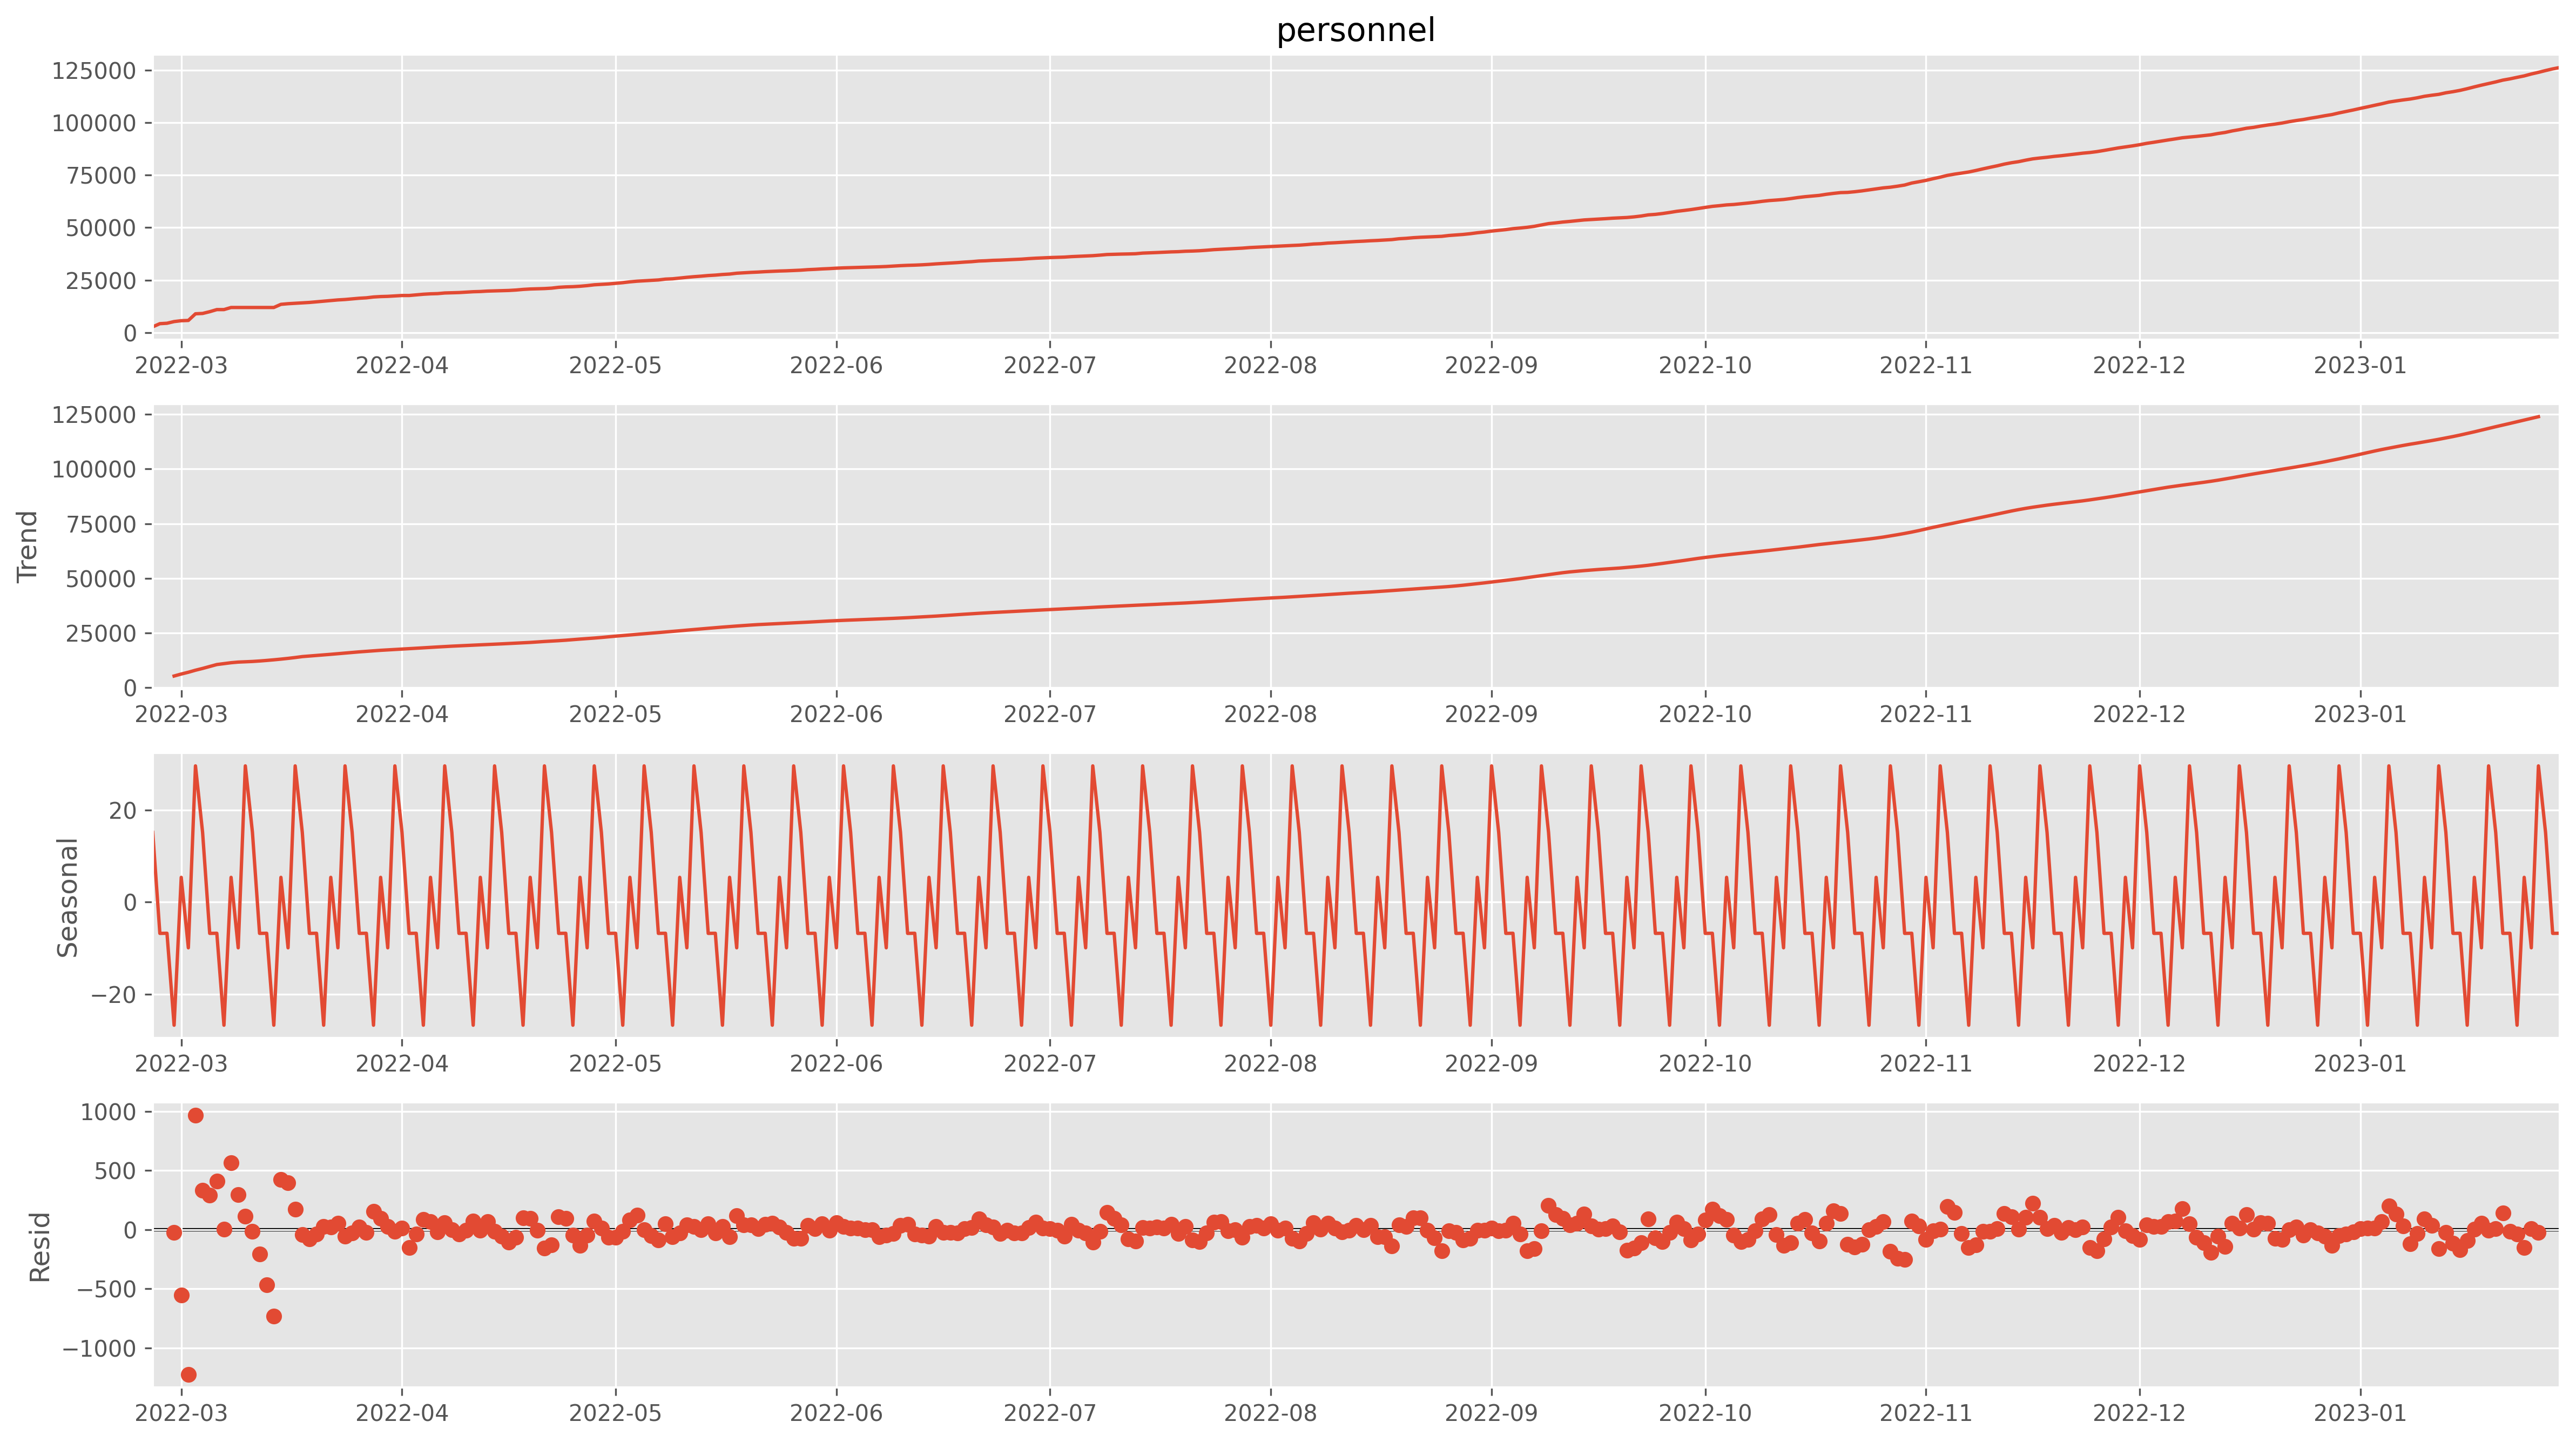

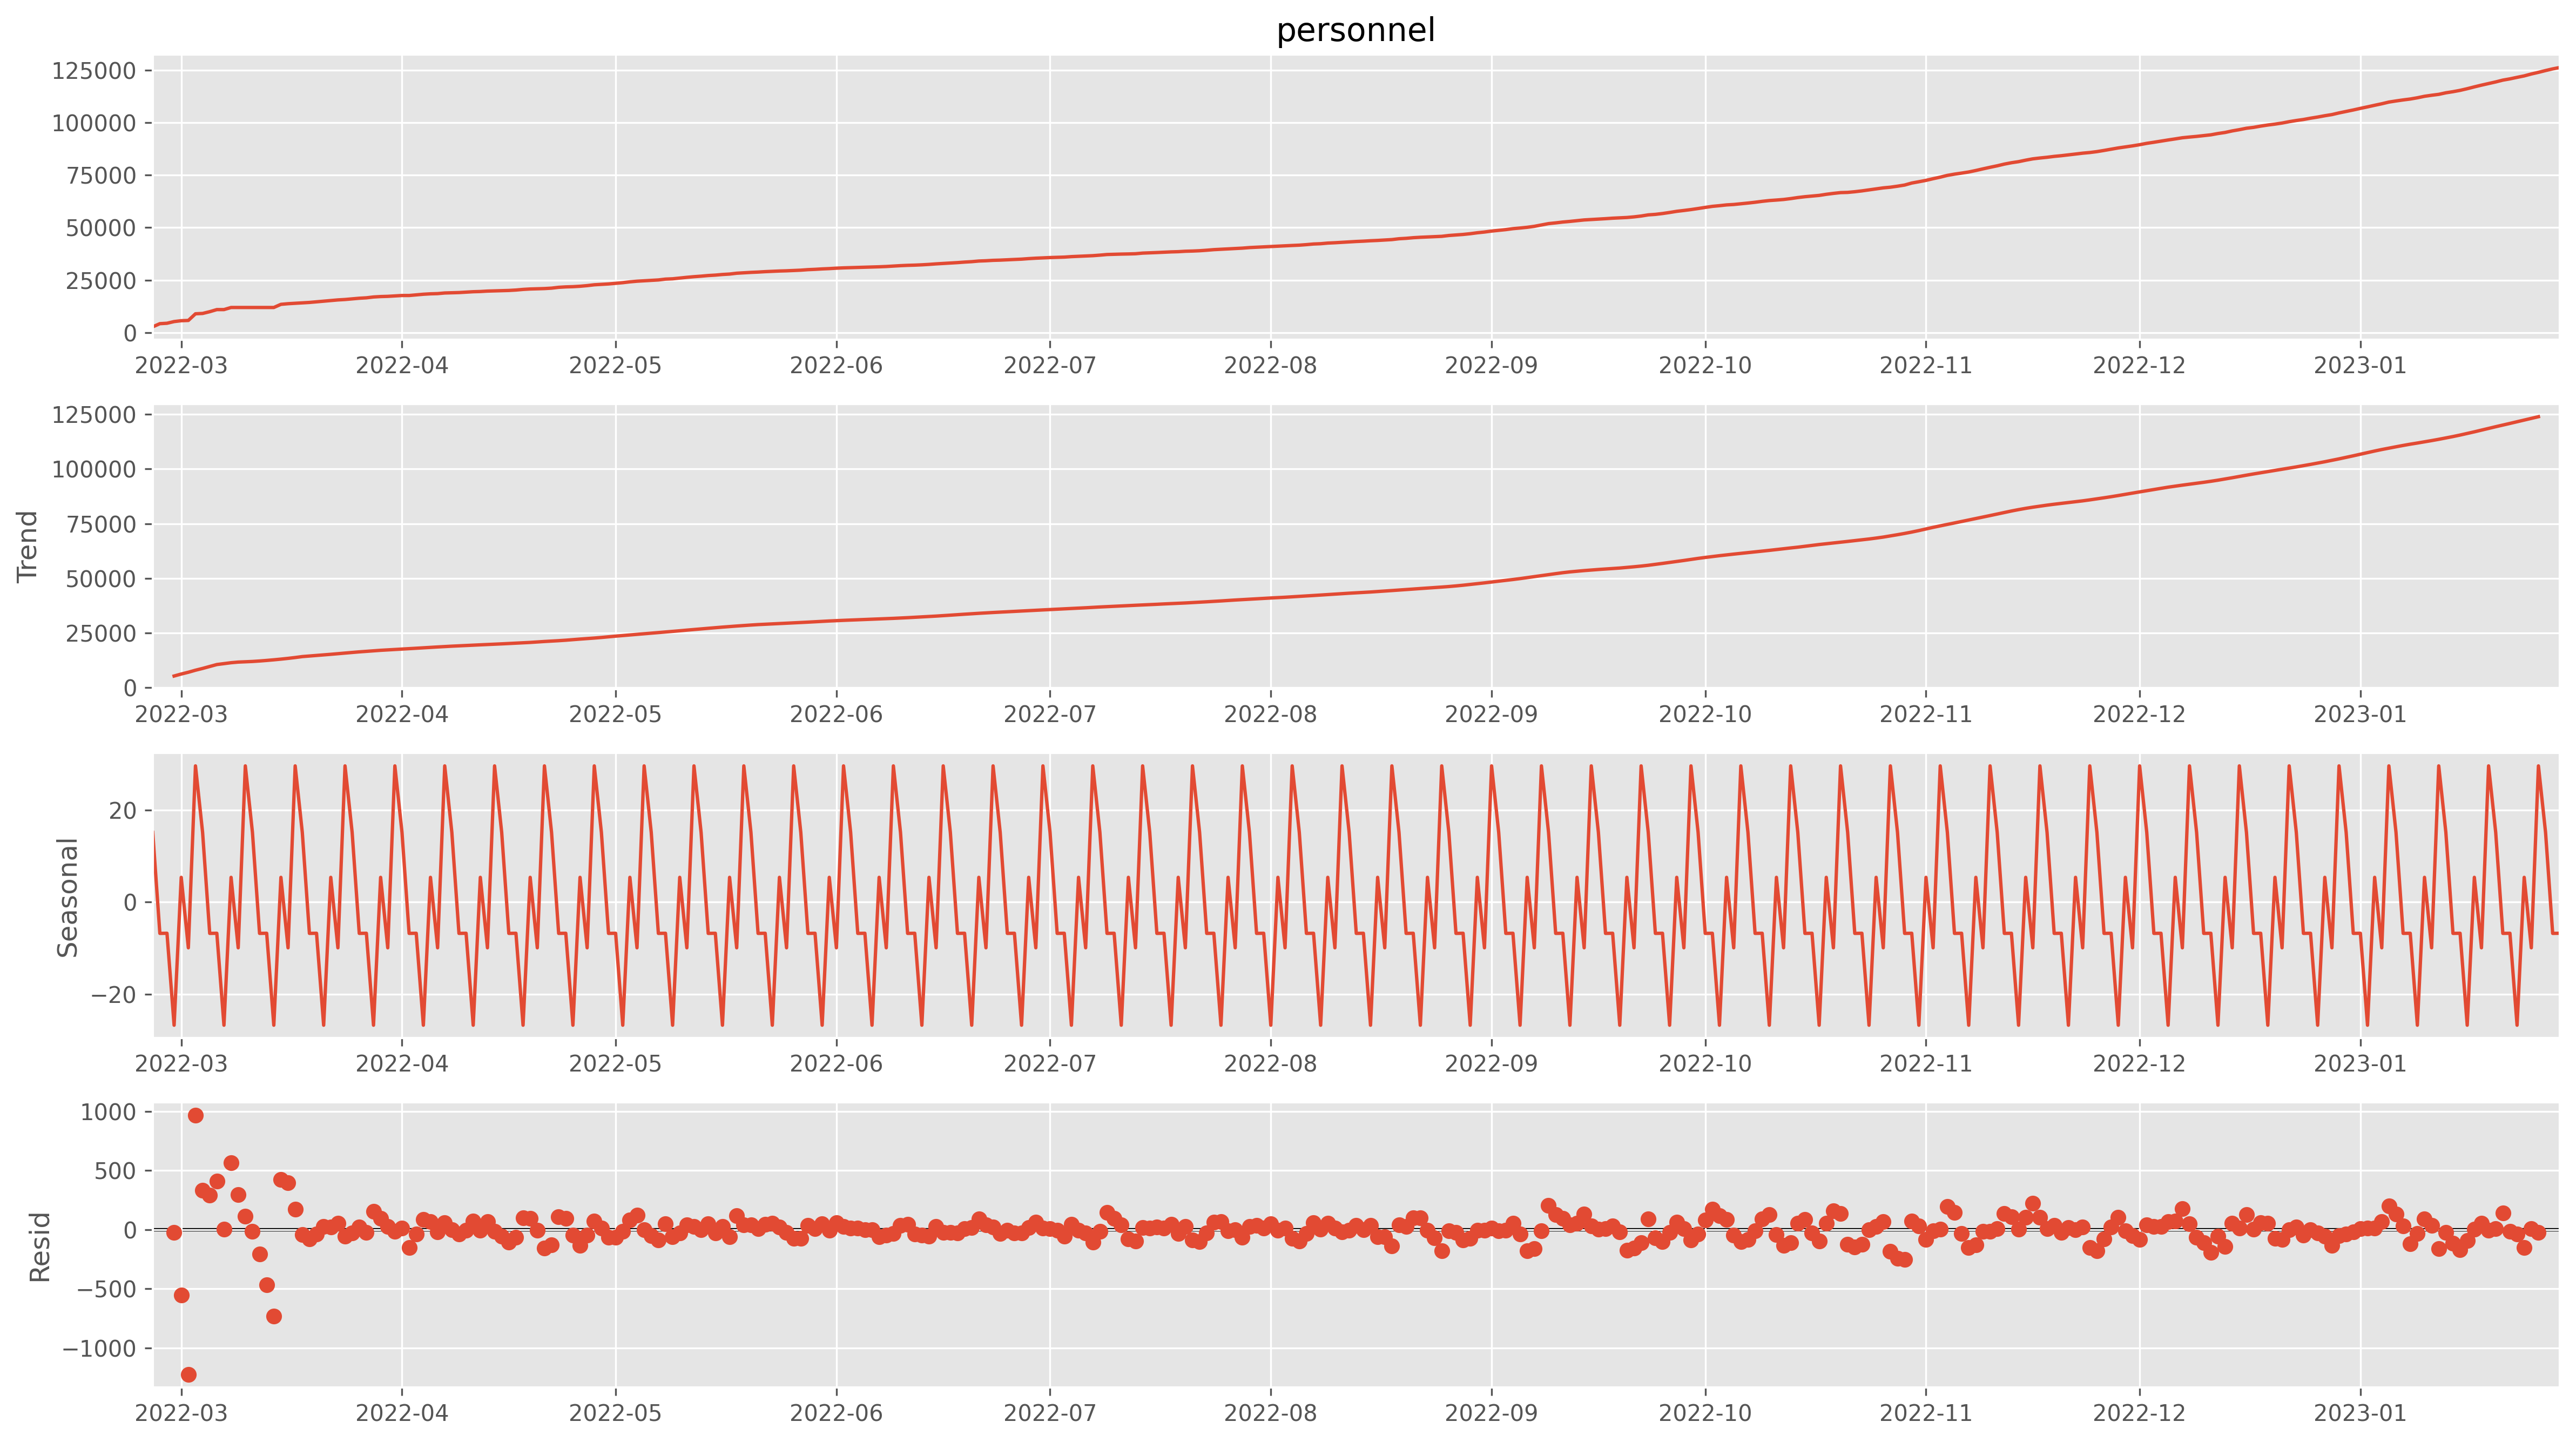

In [14]:
result.plot()

# Now let's investigate the Autocorrelation and partial autocorrelations, so we can fit an arima model on this series.


The following methodology will be used:


1.   Test for stationarity using the augmented dickey fuller test.
2.   If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the value of d. 
3.   If the data is getting stationary then draw the autocorrelation and partial autocorrelation graph of the data.
4.   Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p. 
5.   Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.    




In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ru_losses_per['personnel'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.660539
p-value: 1.000000


This result was already expected because there is clearly a trend in the data. Let's detrend it by differentiating it.

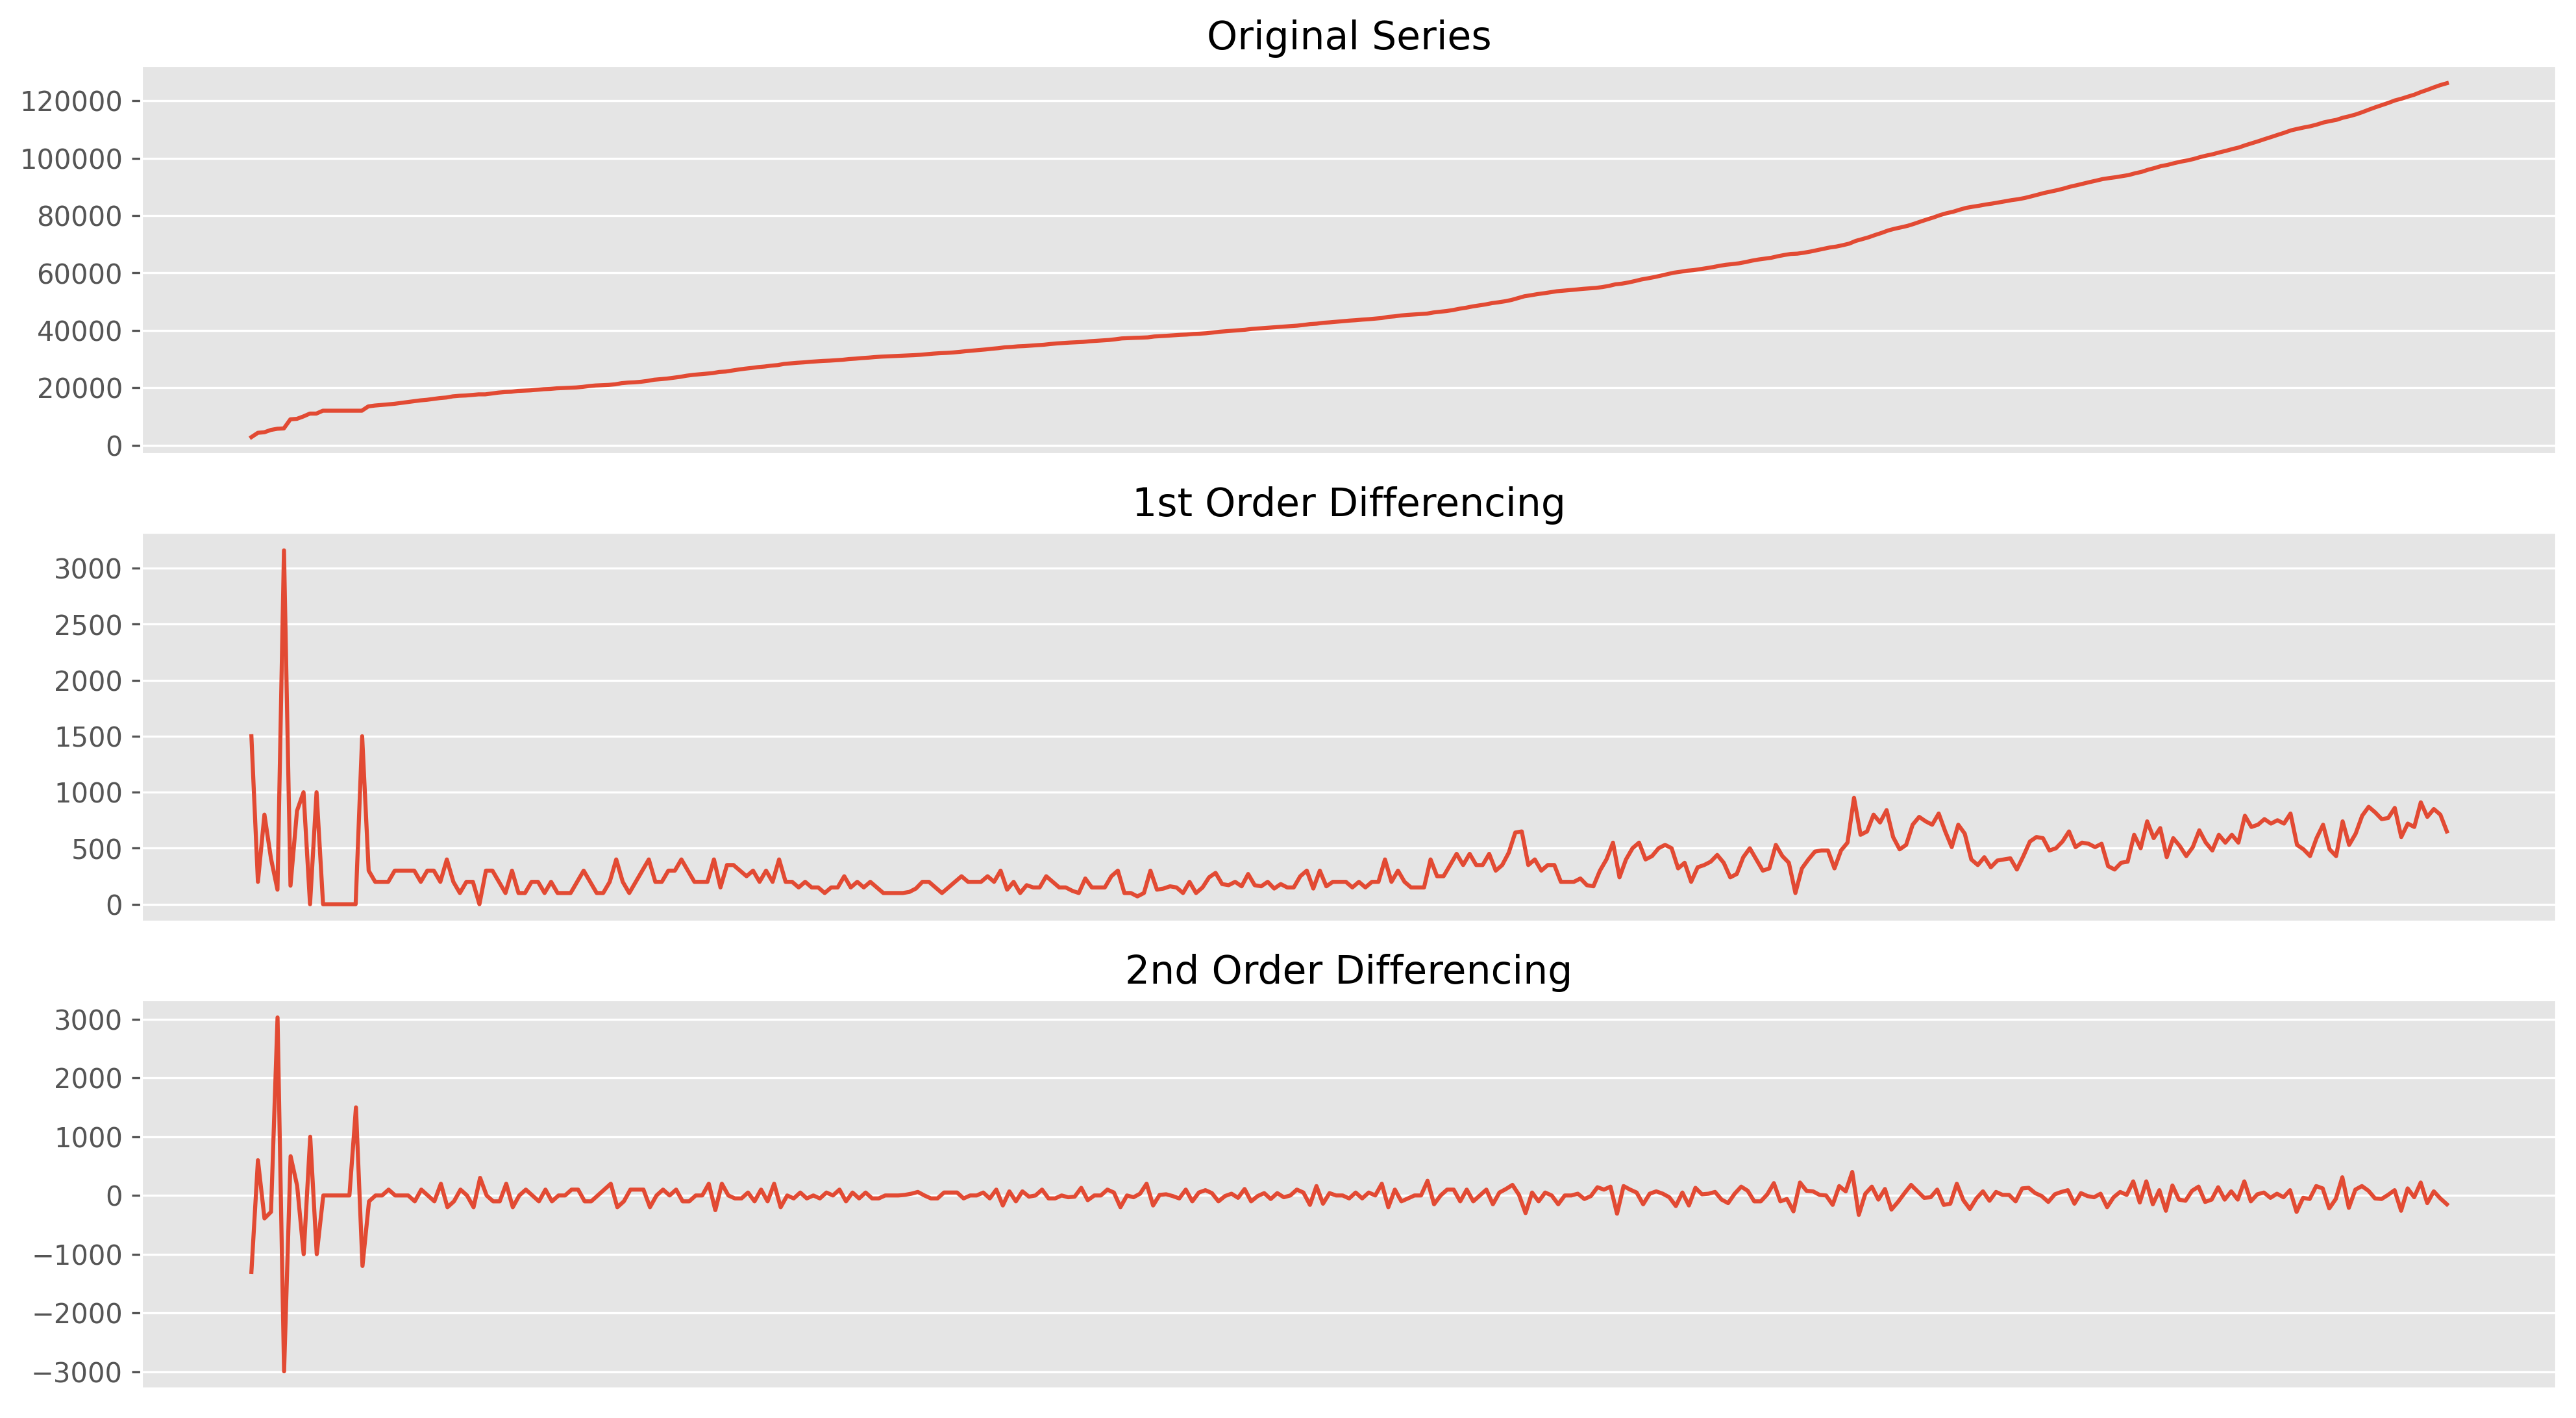

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(ru_losses_per['personnel'])
ax1.set_title('Original Series')
ax1.set_xticks([])
#1st Differencing
ax2.plot(ru_losses_per['personnel'].diff().dropna())
ax2.set_title('1st Order Differencing')
ax2.set_xticks([])
# 2nd Differencing
ax3.plot(ru_losses_per['personnel'].diff().diff().dropna())
ax3.set_title('2nd Order Differencing')
ax3.set_xticks([])
plt.show()

Performing adFuller test on the differenced series

In [17]:
result = adfuller(ru_losses_per['personnel'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.784476
p-value: 0.000058


In [18]:
result = adfuller(ru_losses_per['personnel'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.260699
p-value: 0.000000


The first differencing already makes the trend stationary according to the test. But we can see that the 2nd differenced series, makes in less noisy. In the modeling fase lets try using $\text{d}\in\{1,2\}$ 

## Investigating ACF to get good hints for q

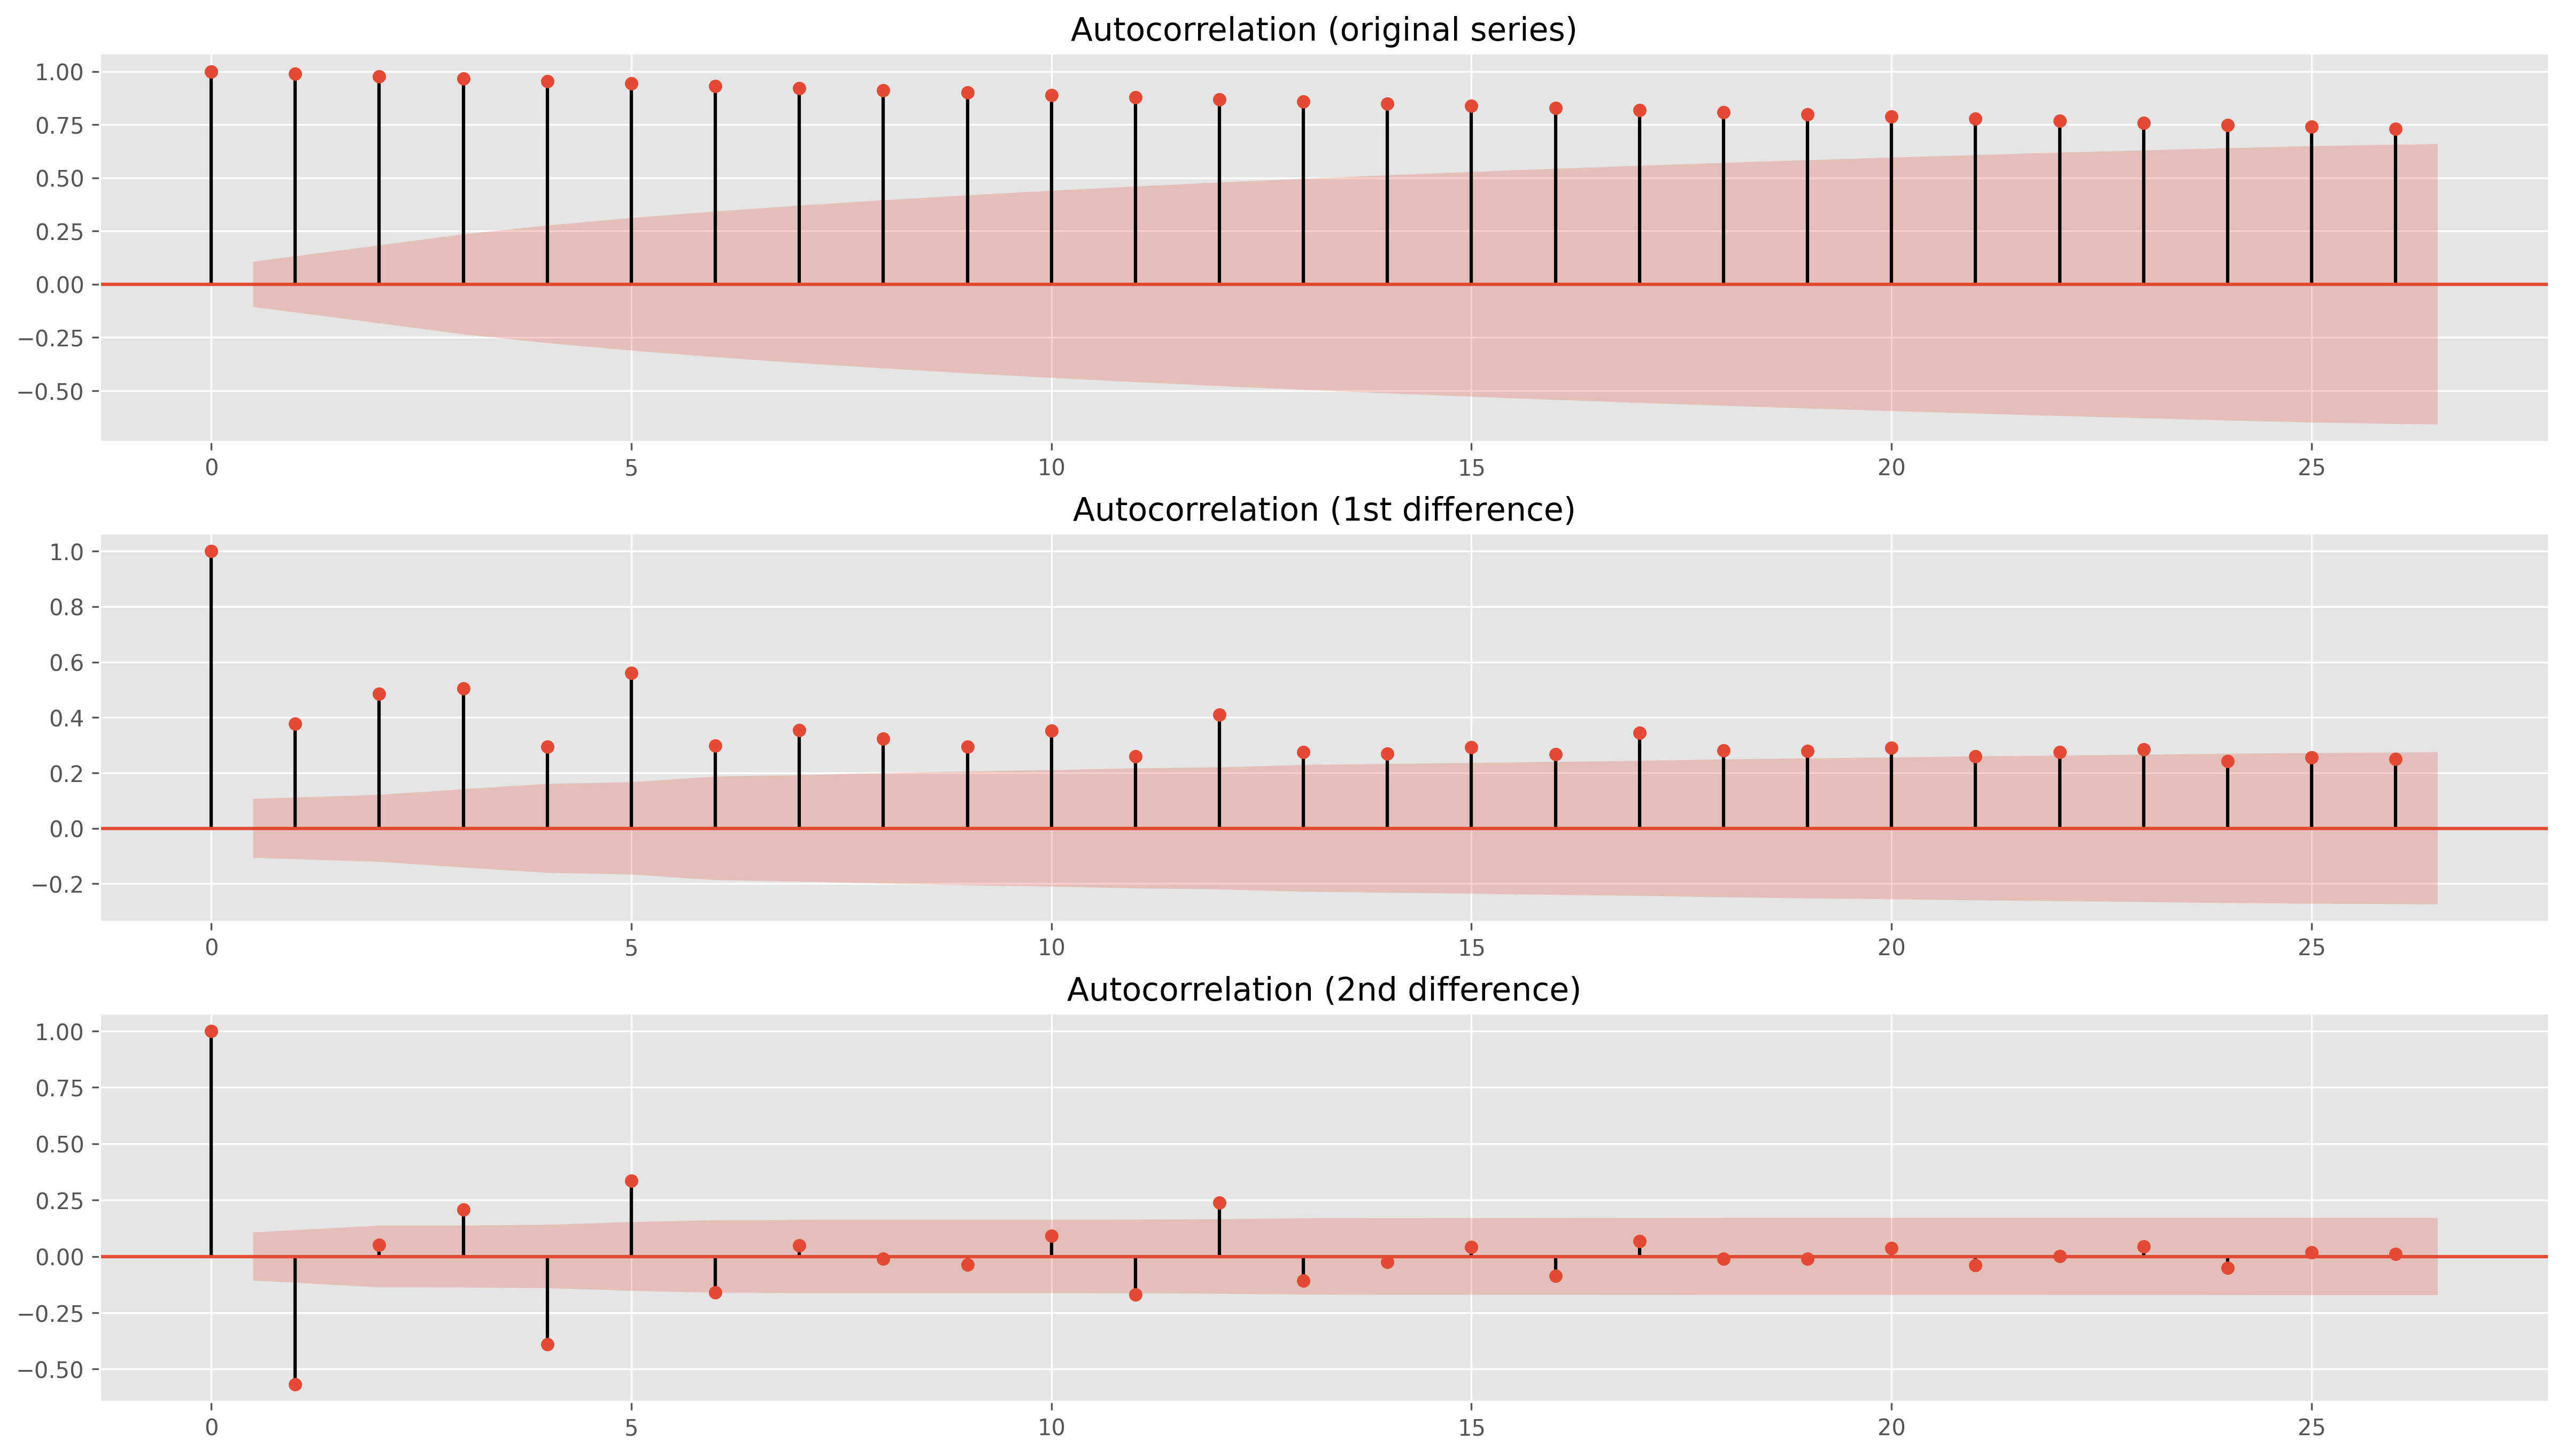

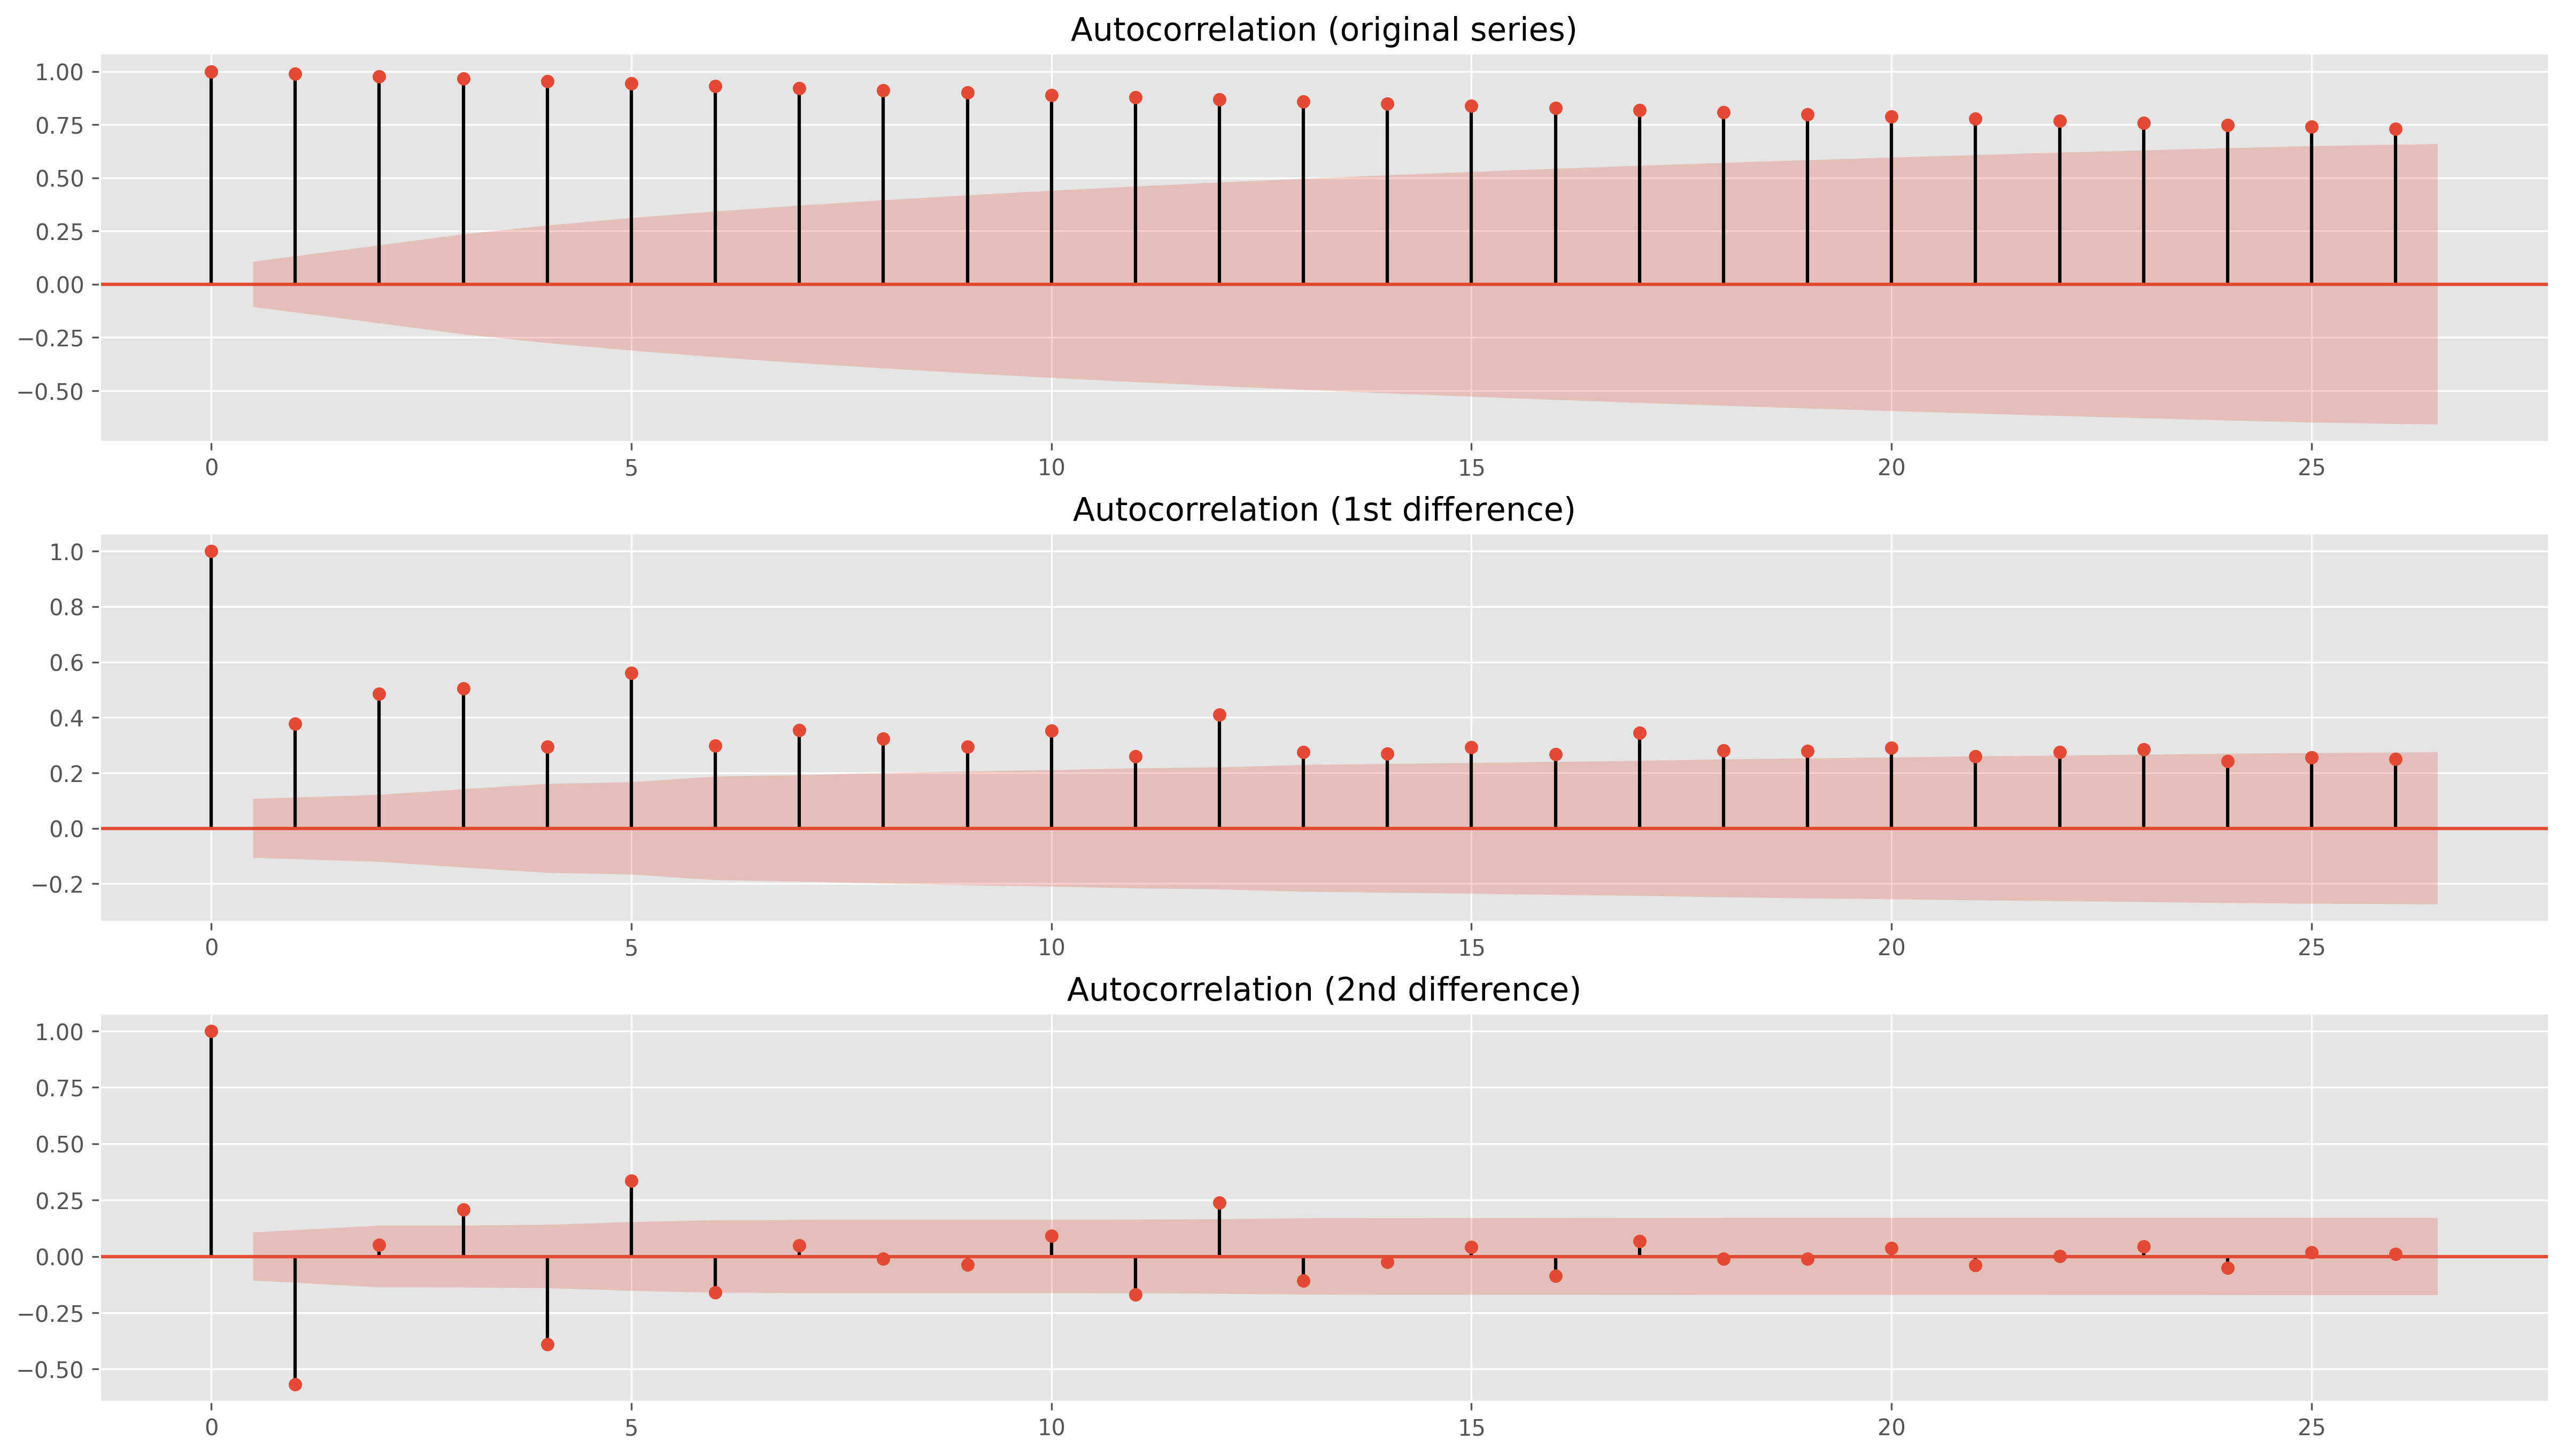

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.tight_layout(h_pad = 2)
plot_acf(ru_losses_per['personnel'], ax=ax1, title='Autocorrelation (original series)')
plot_acf(ru_losses_per['personnel'].diff().dropna(), ax=ax2, title='Autocorrelation (1st difference)')
plot_acf(ru_losses_per['personnel'].diff().diff().dropna(), ax=ax3, title='Autocorrelation (2nd difference)')

The favorite candidates for q here is 11(because we include the zero stick in the count this time). Bu lets also try the values of 12 and 13. So $\text{q}\in\{11,12, 13\}$ 

## Investigating Partial auto correlation to get the value of p.

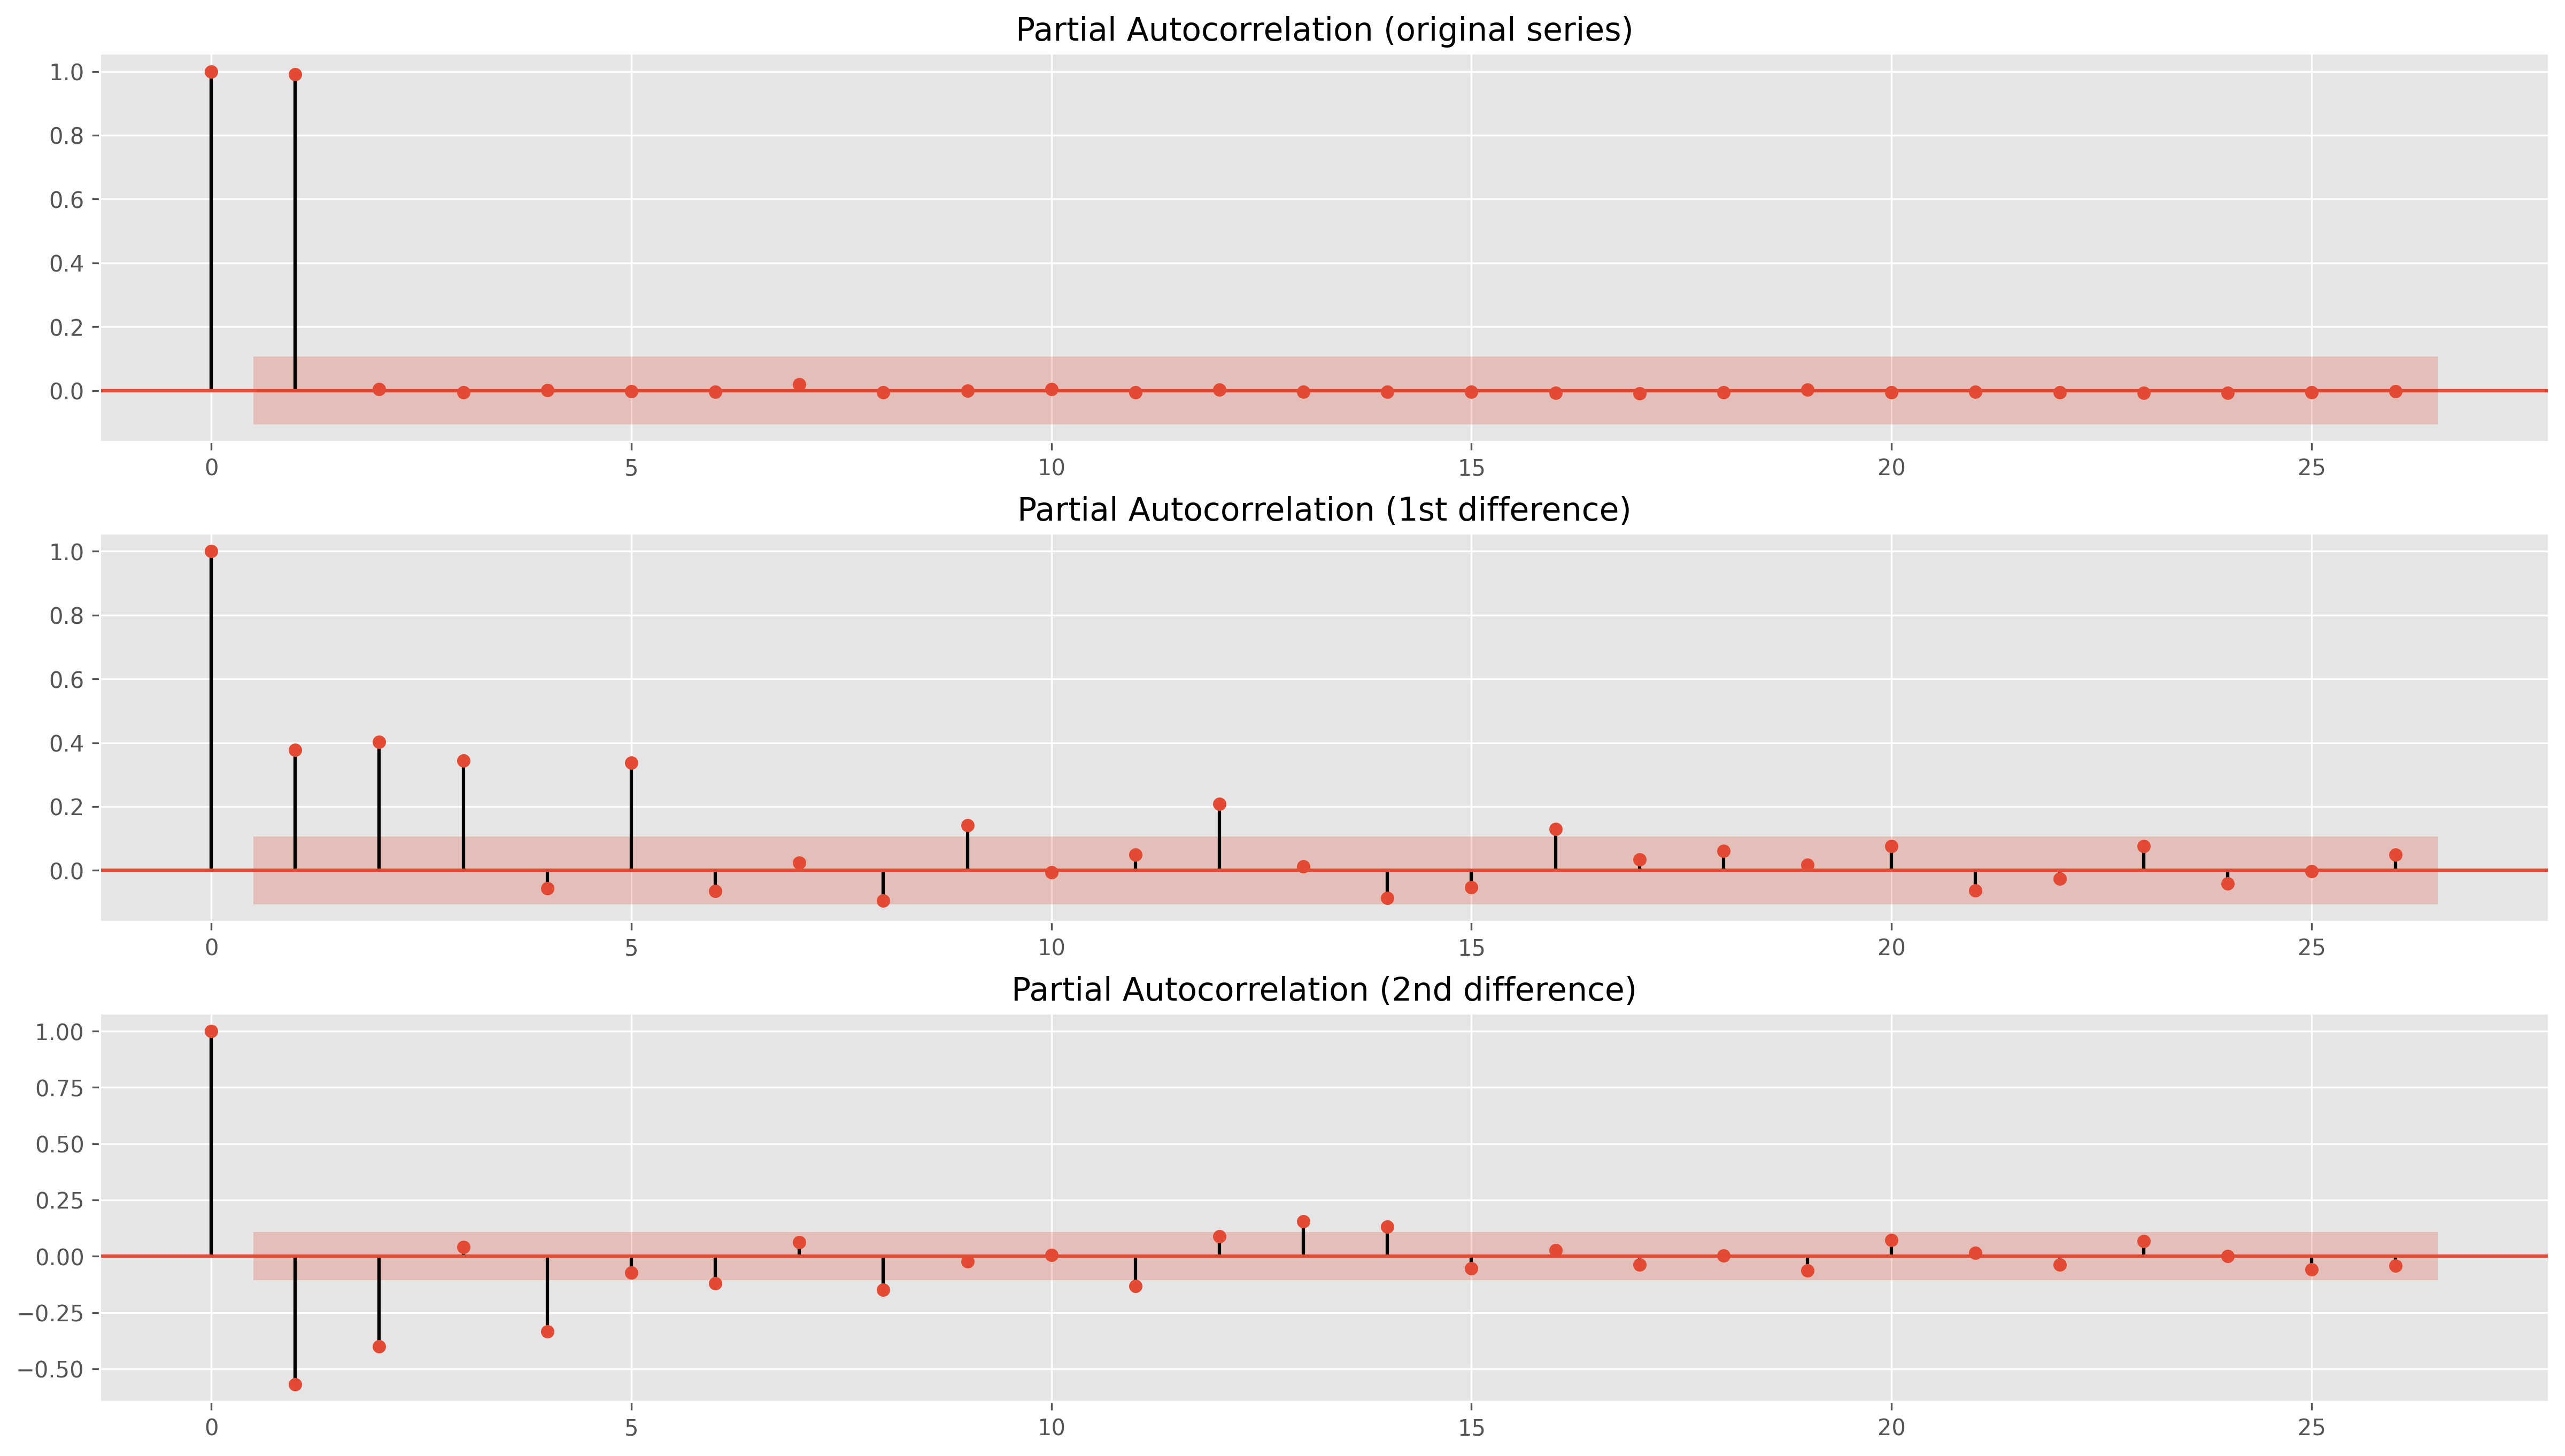

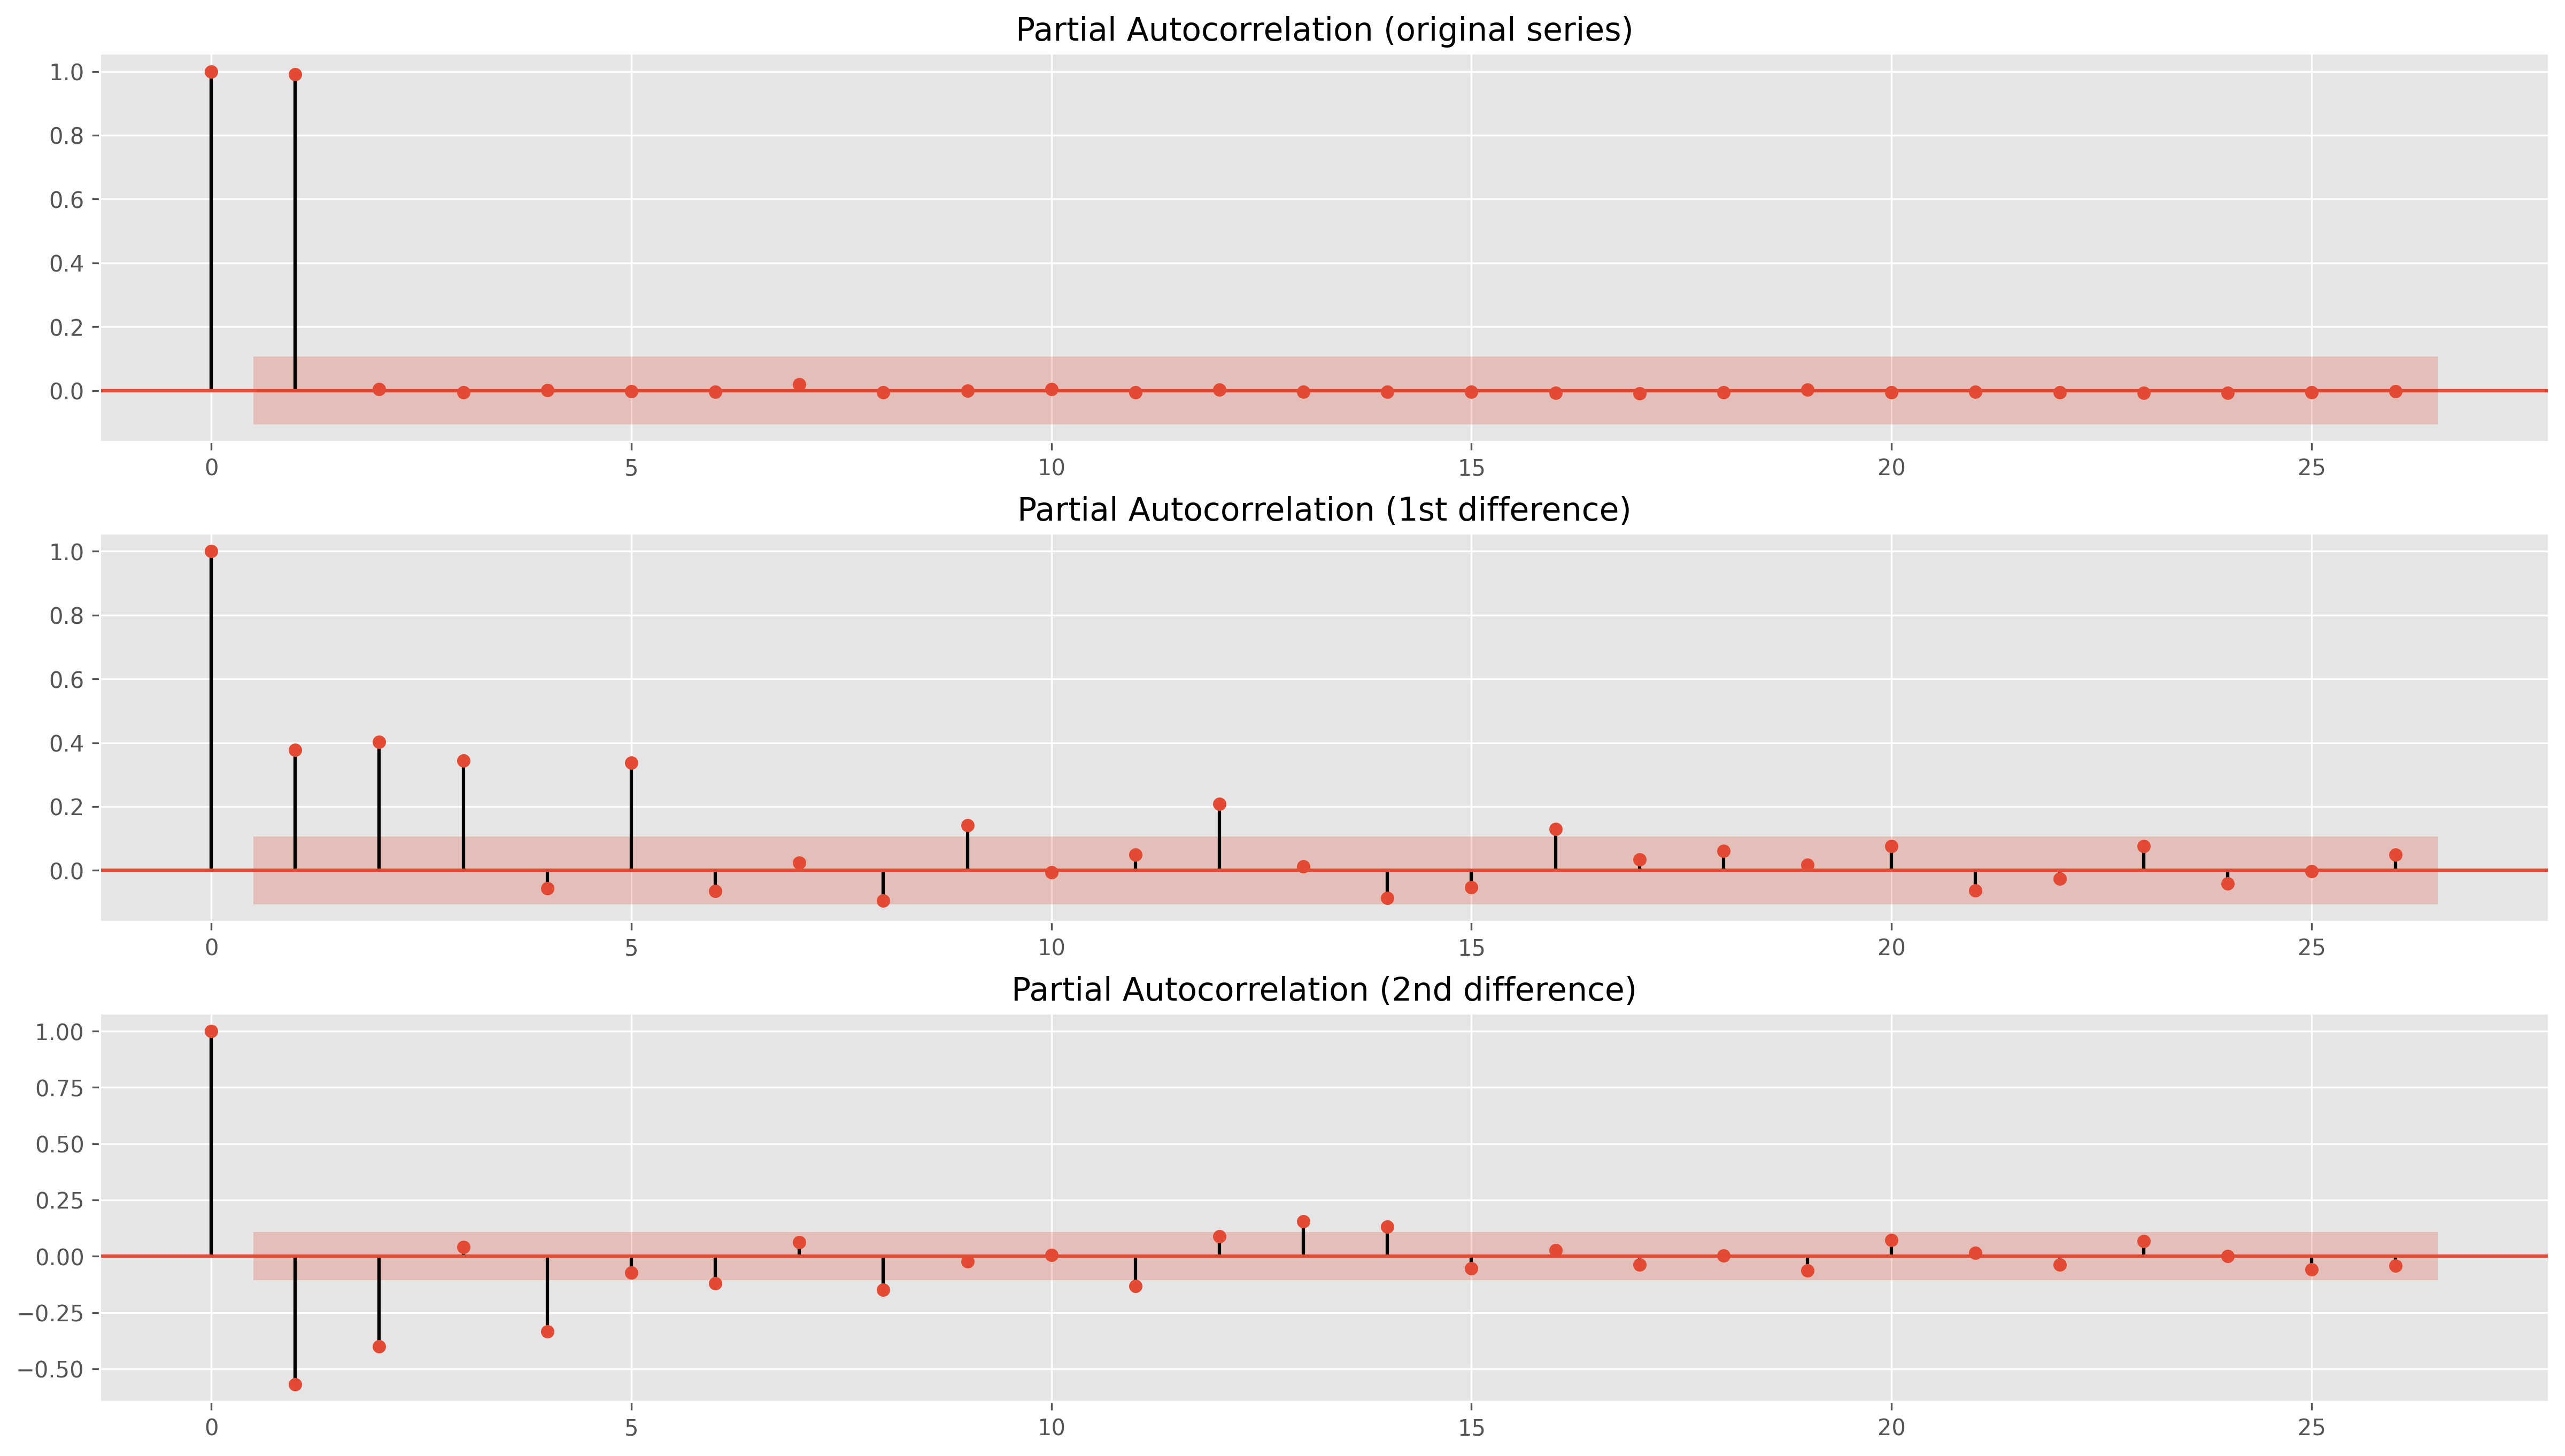

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.tight_layout(h_pad = 2)
plot_pacf(ru_losses_per['personnel'], ax=ax1, title='Partial Autocorrelation (original series)')
plot_pacf(ru_losses_per['personnel'].diff().dropna(), ax=ax2, title='Partial Autocorrelation (1st difference)')
plot_pacf(ru_losses_per['personnel'].diff().diff().dropna(), ax=ax3, title='Partial Autocorrelation (2nd difference)')

Conclusion: When we look at the 1st difference PACF graph, we see that  only the first 3 lags are significant. So I will use p = 3.
OBS: P refers to the AR(autoregressive) part of the model. In this case "the zero stick" does not count. That's why p=3 and not 4.

# Modeling the series with ARIMA
I will perform a grid search on the reduced space of possibilities for p,q, d. Then the best model will be chosen based on [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion).
The LOWER the AIC, the better.

In [21]:
best_model = 0
for d in [1, 2]:
    for q in [11, 12, 13]:
        m = SARIMAX(ru_losses_per['personnel'], order=(3, q, d))
        model_fit = m.fit()
        if not best_model or model_fit.aic < best_model.aic:
            best_model = model_fit 

In [22]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              personnel   No. Observations:                  339
Model:              SARIMAX(3, 11, 2)   Log Likelihood               -3088.131
Date:                Sat, 04 Feb 2023   AIC                           6188.261
Time:                        16:49:16   BIC                           6211.020
Sample:                    02-25-2022   HQIC                          6197.341
                         - 01-29-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9531      0.015   -127.558      0.000      -1.983      -1.923
ar.L2         -1.6081      0.024    -66.000      0.000      -1.656      -1.560
ar.L3         -0.5110      0.014    -35.710      0.000      -0.539      -0.483
ma.L1         -1.9970      0.026    -77.841      0.000      -2.047      -1.947
ma.L2          0.9971      0.026     38.398      0.000       0.946       1.048
sigma2      8.696e+06   5.91e-09   1.47e+15      0.000     8.7e+06     8.7e+06
===================================================================================
Ljung-Box (L1) (Q):                  98.86   Jarque-Bera (JB):              5691.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+29. Standard errors may be unstable.
"""

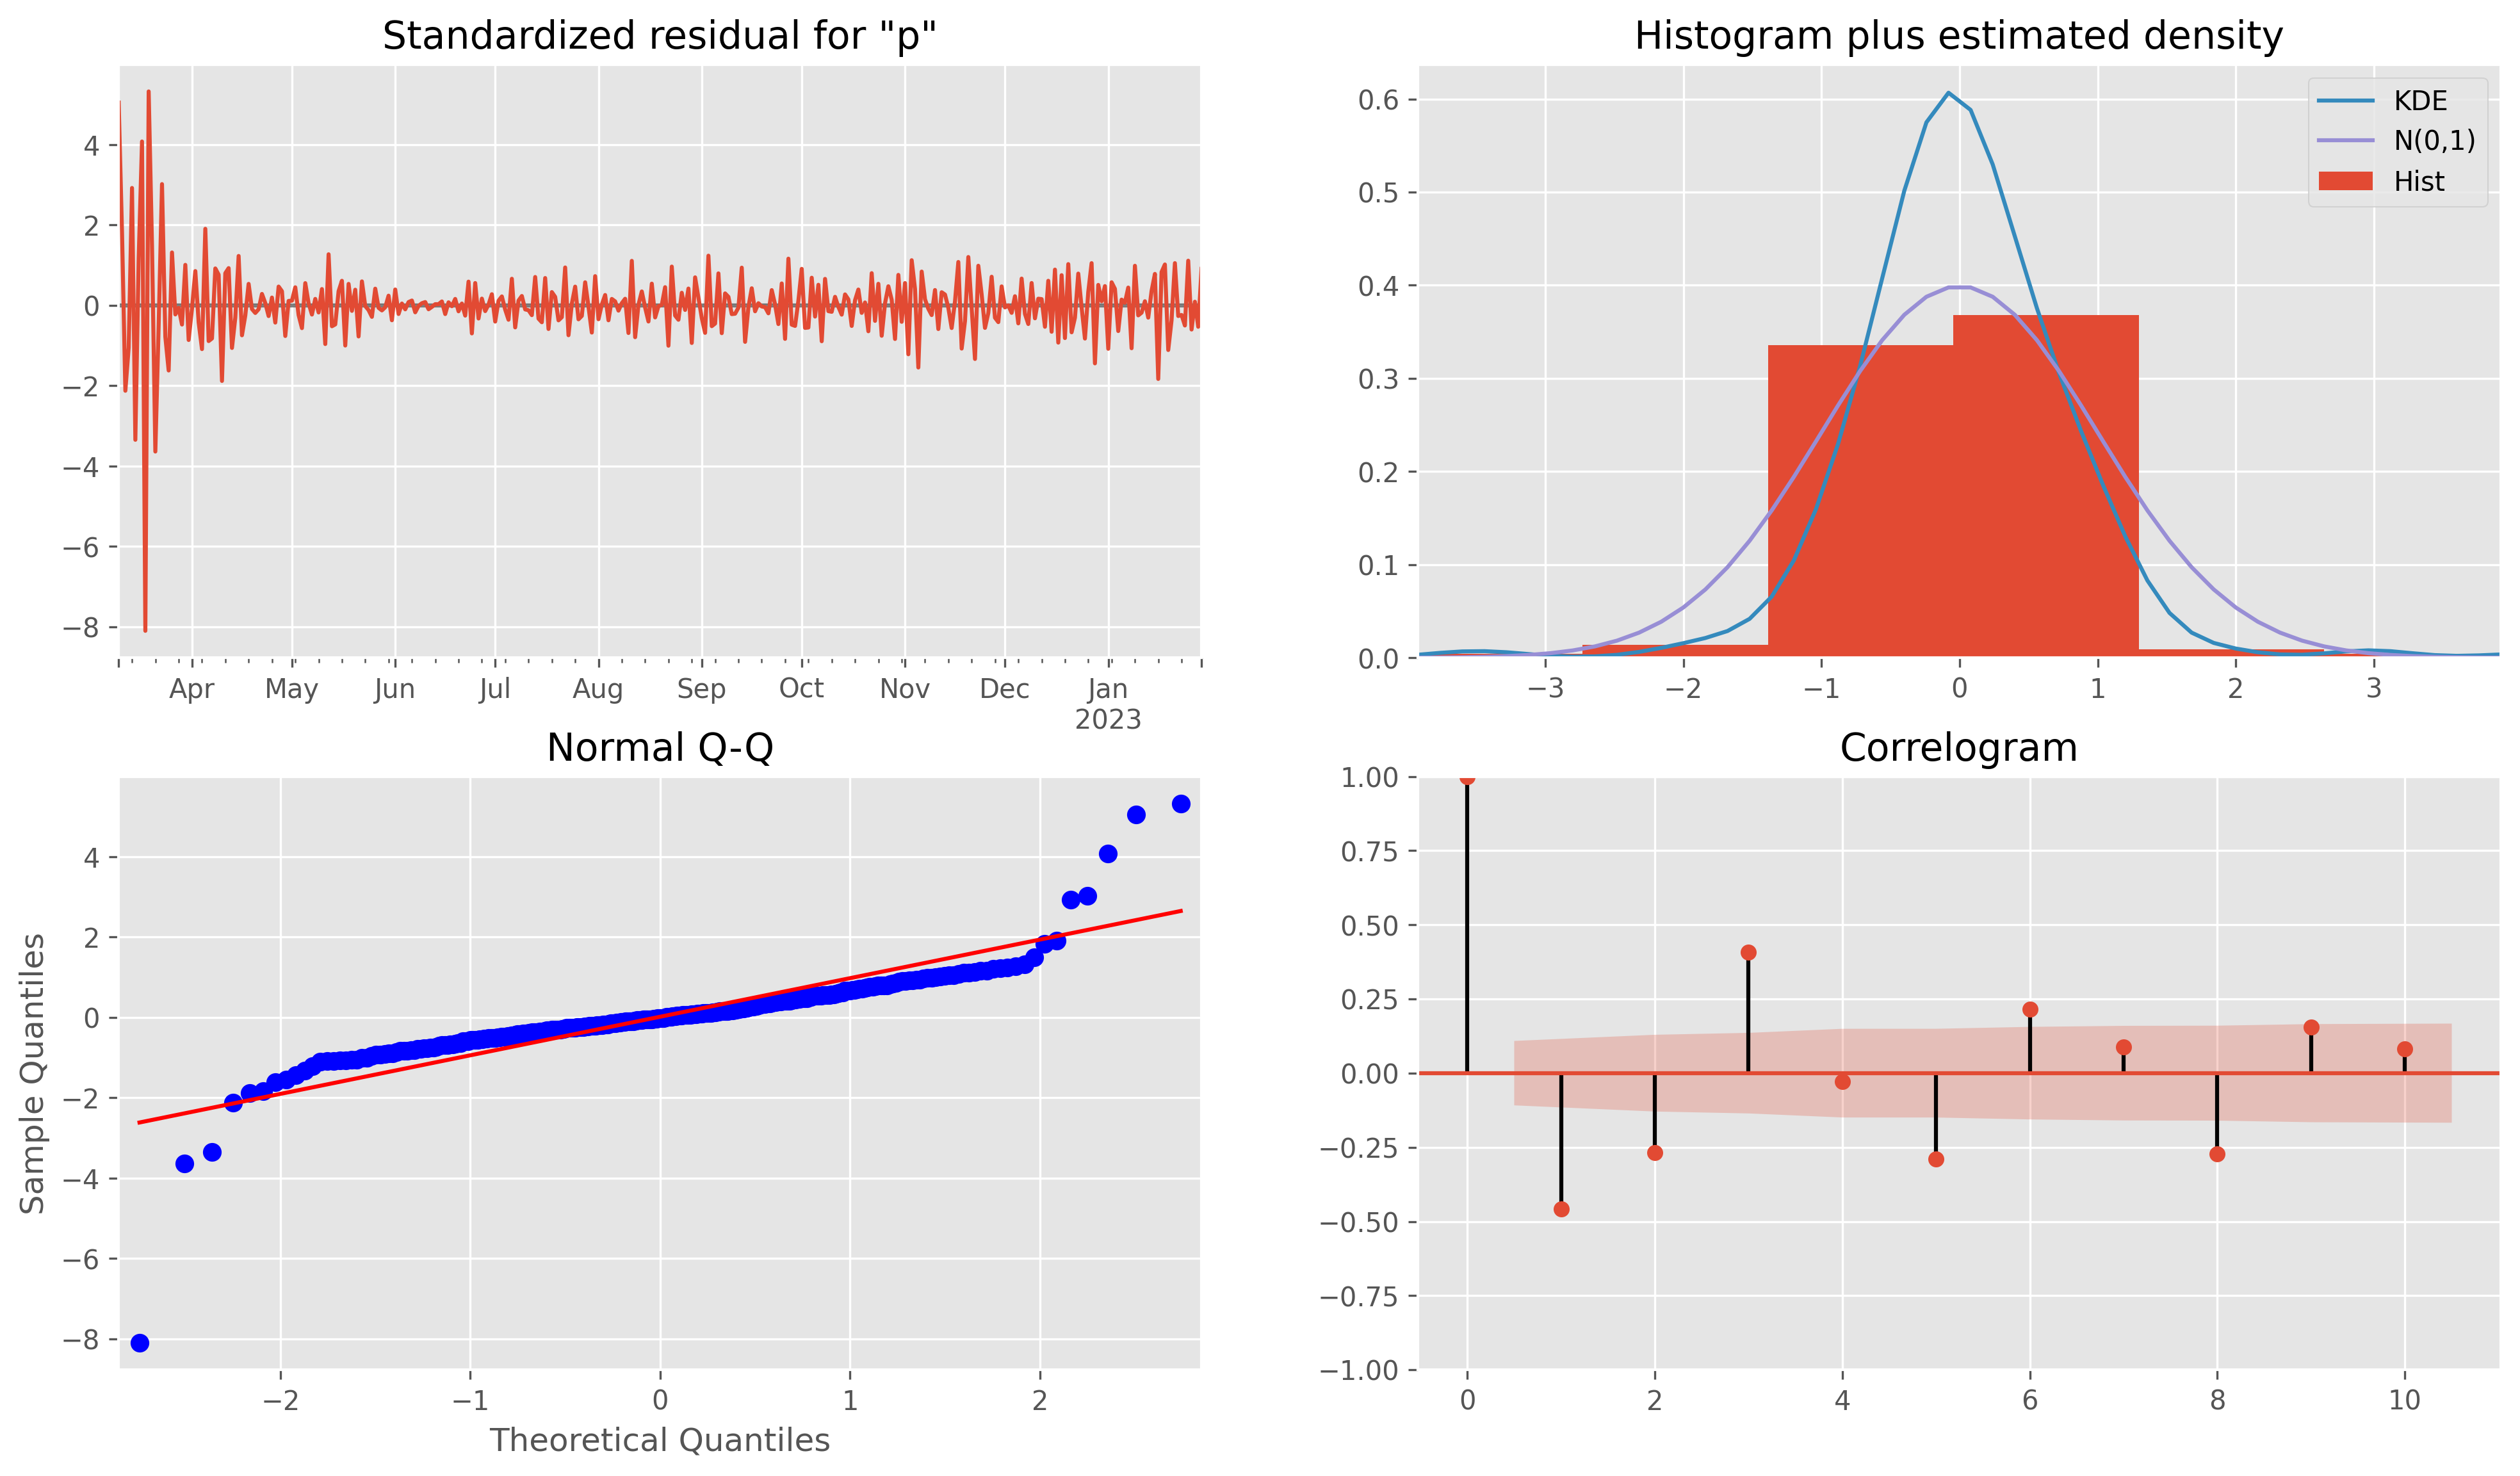

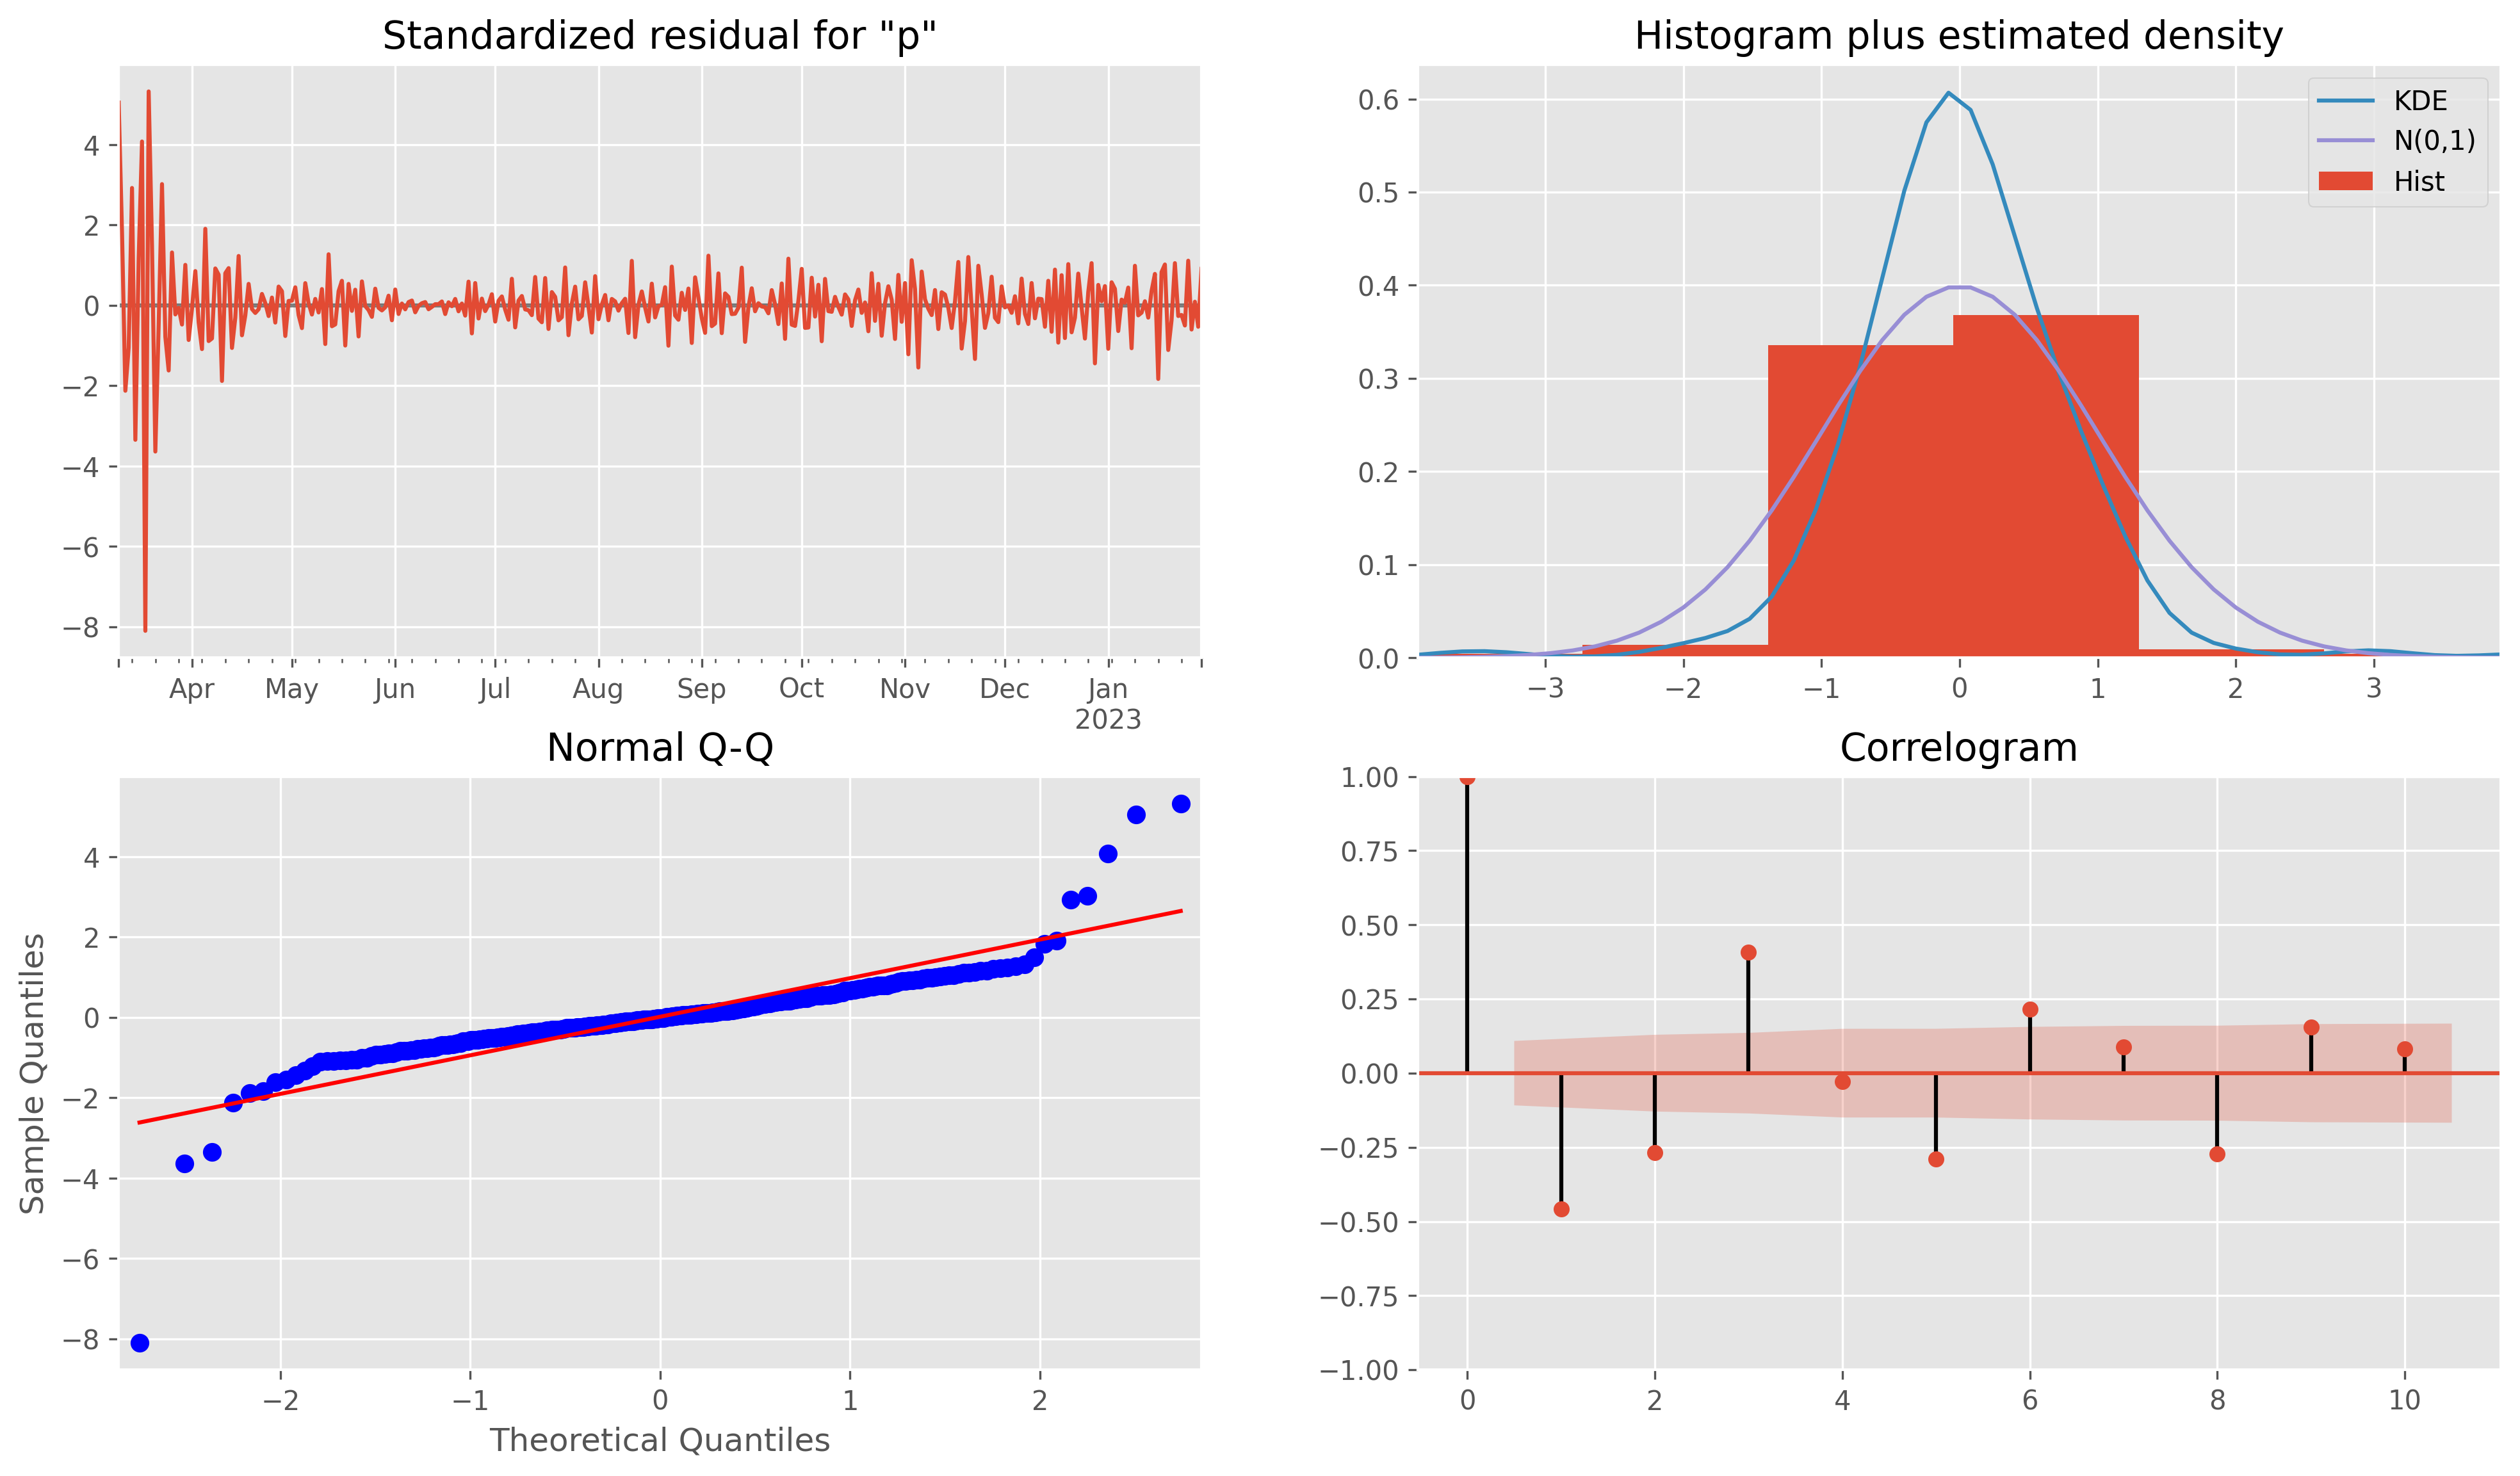

In [23]:
model_fit.plot_diagnostics()

In [24]:
ru_losses_per['personnel'].tail()

date
2023-01-25    123080
2023-01-26    123860
2023-01-27    124710
2023-01-28    125510
2023-01-29    126160
Name: personnel, dtype: int64

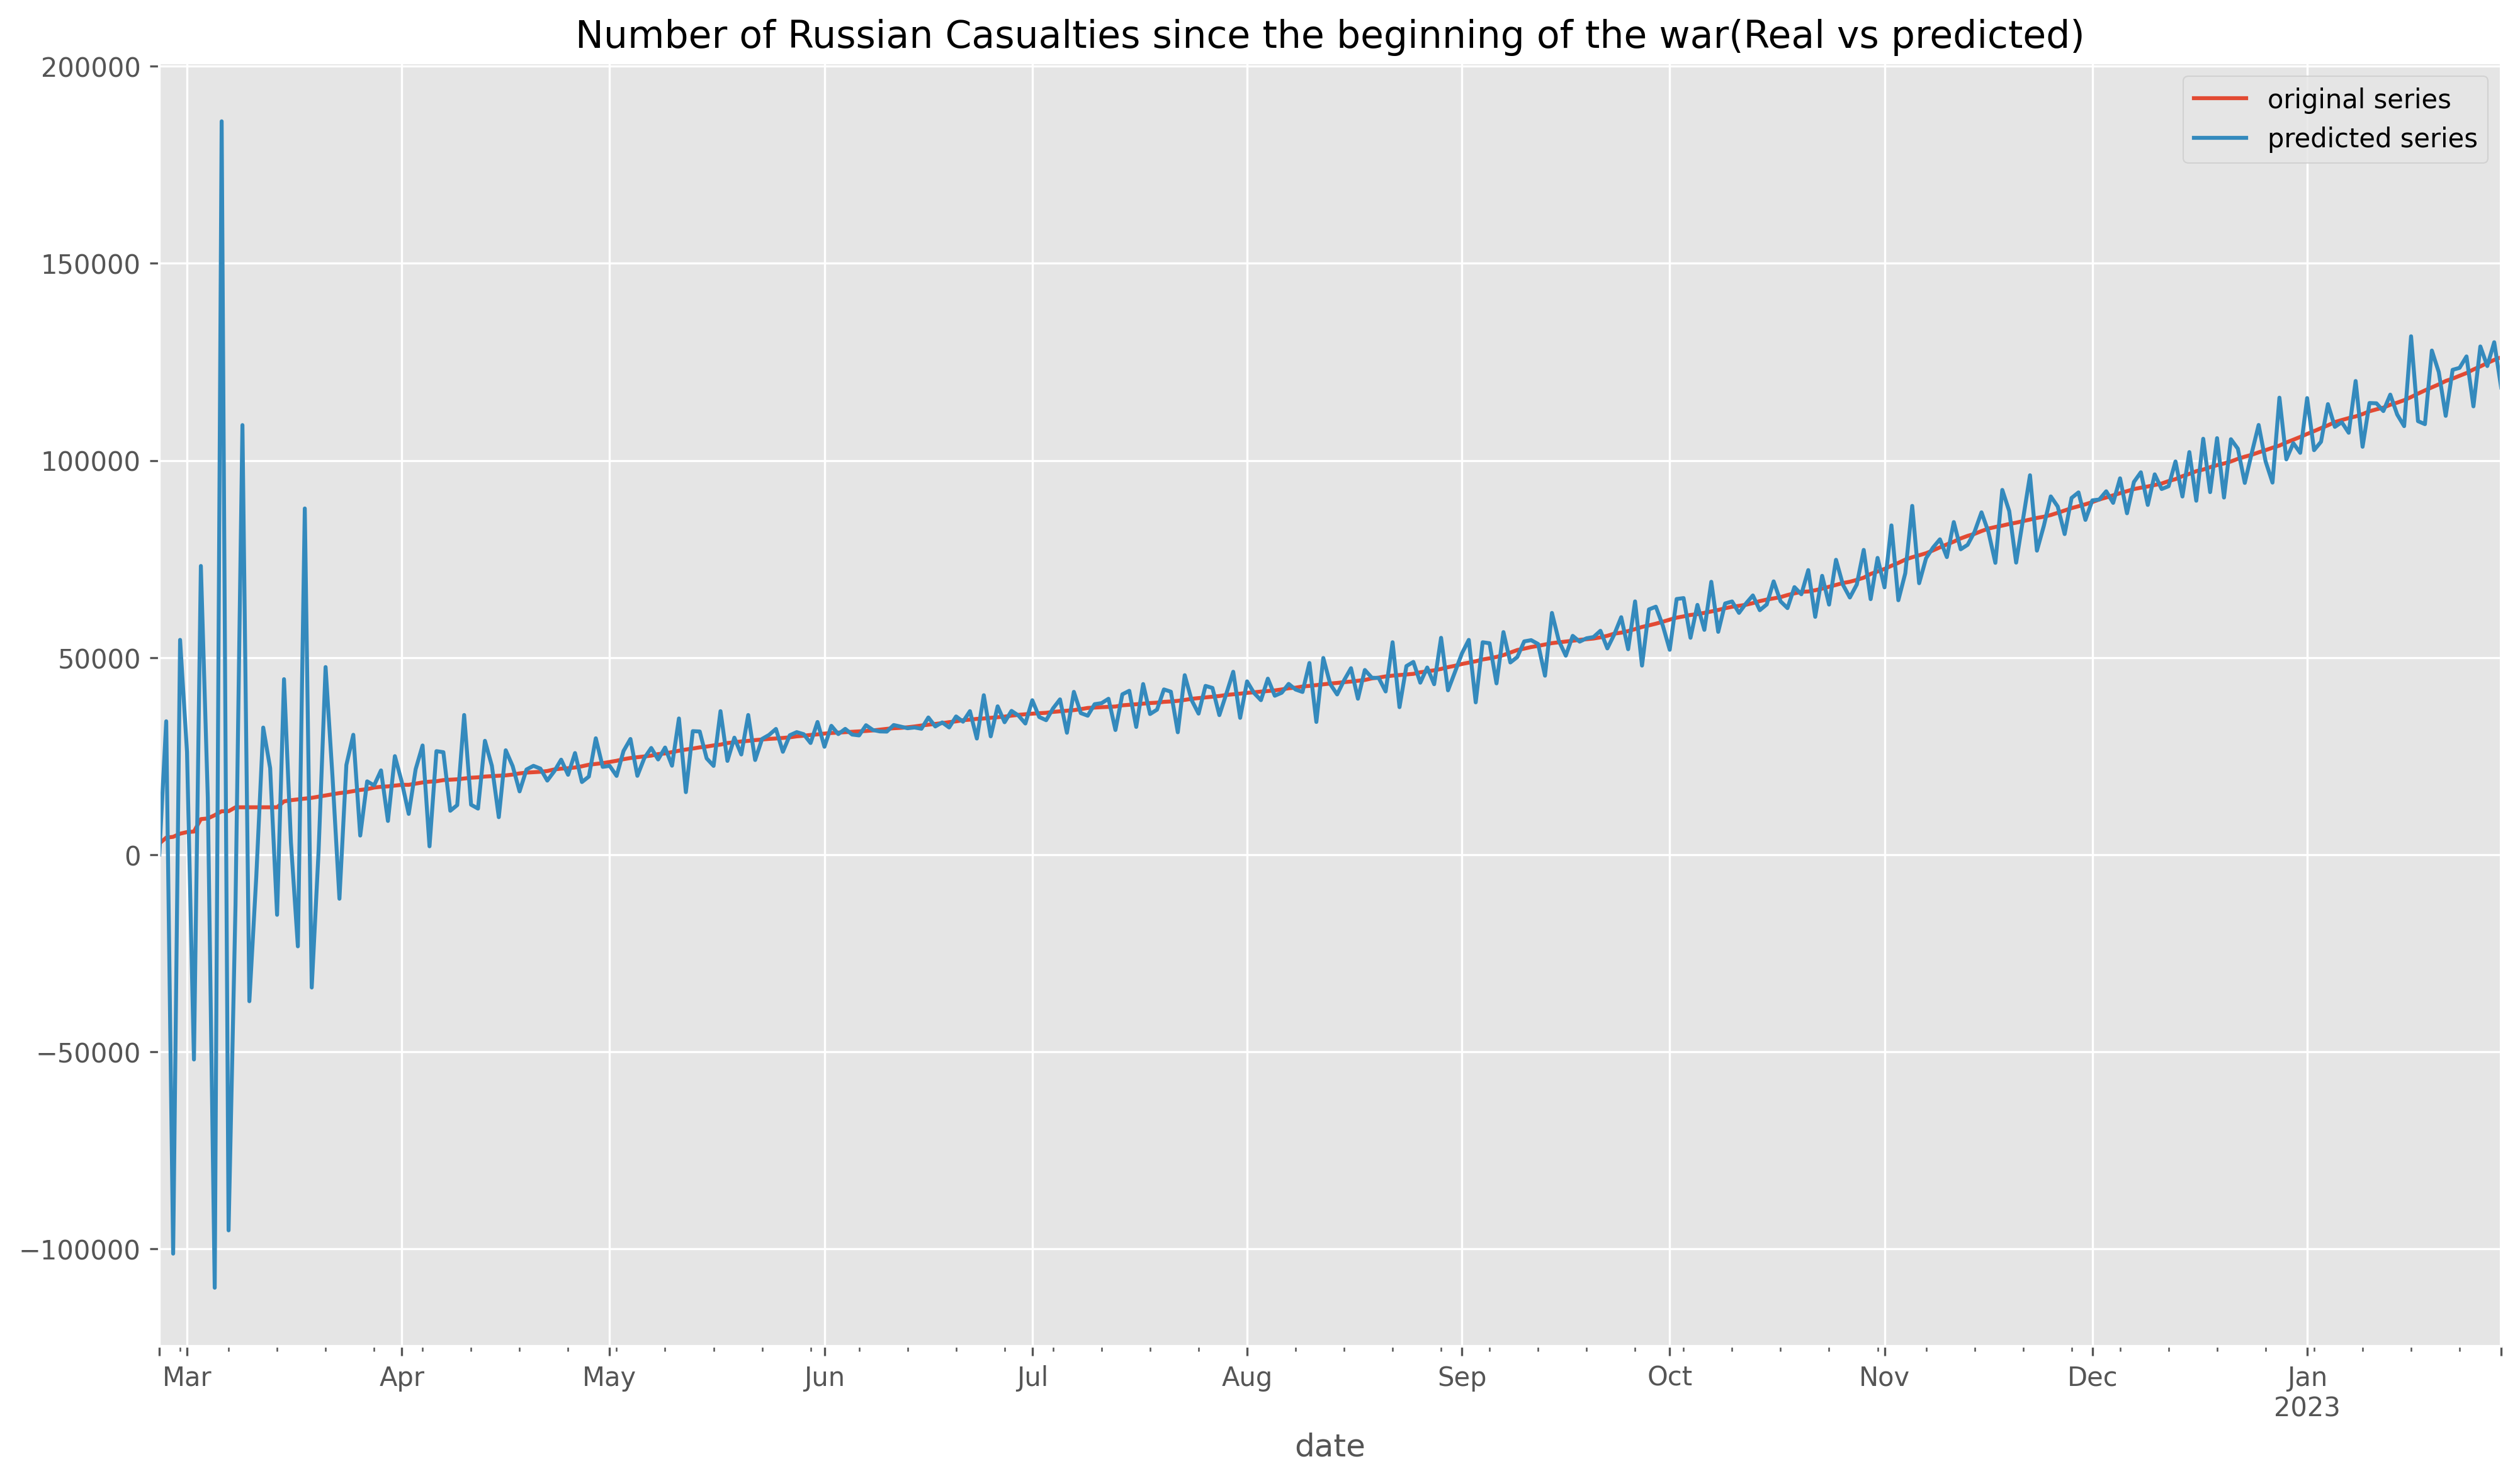

In [25]:
ru_losses_per['personnel'].plot(label='original series')
preds = model_fit.predict()
preds.plot(label='predicted series')
plt.title('Number of Russian Casualties since the beginning of the war(Real vs predicted)')
plt.legend()
plt.show()

For some reason that I don't understand, The predictions are too agressive. Notheless here is the graph of it

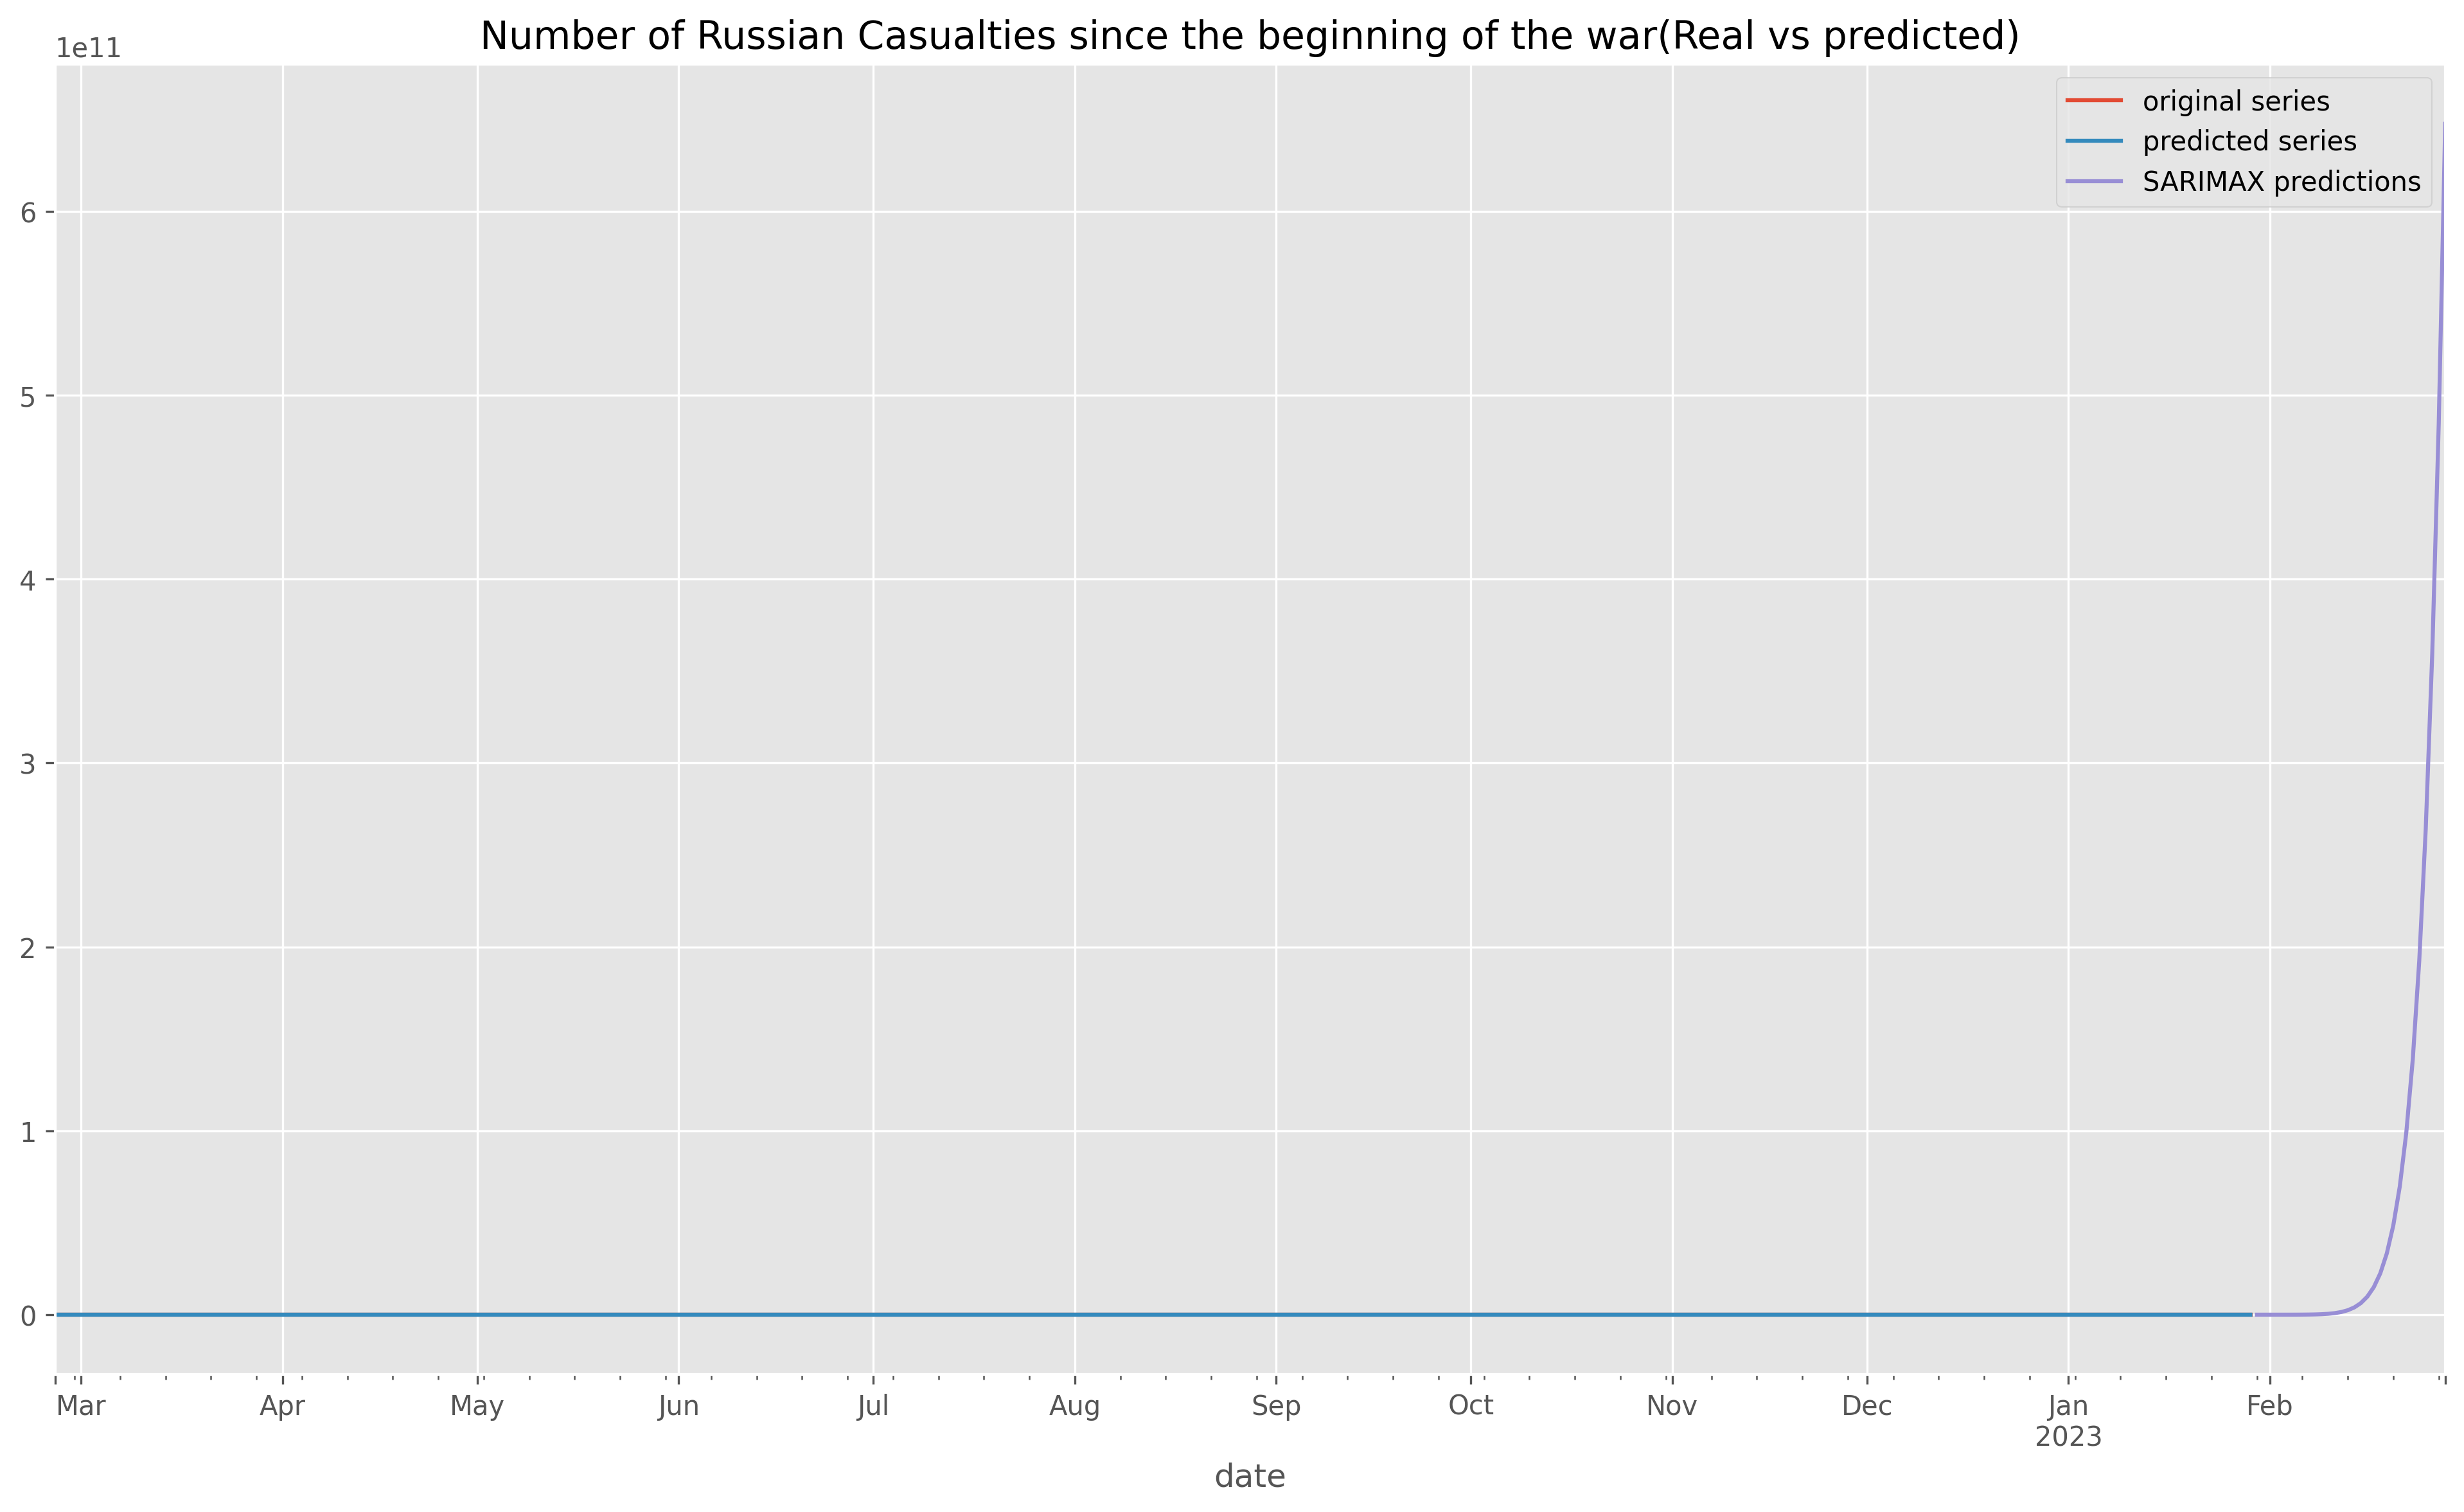

In [26]:
ru_losses_per['personnel'].plot(label='original series')
preds = model_fit.predict()
preds.plot(label='predicted series')
ous_preds = model_fit.forecast(steps=30)
ous_preds.plot(label='SARIMAX predictions')
plt.title('Number of Russian Casualties since the beginning of the war(Real vs predicted)')
plt.legend()
plt.show()

# Time series Forecasting

We are going to perform a simple experiment. I'm going to convert a time-series problem into a regression problem. I could engineer several features here, but I am simply going to reframe the data set so we can answer the following question: Given 10 days of casualties info, how are the next 20 days(rest of the month) going to be like? 

In [66]:
train = ru_losses_per['personnel'].values.reshape(1, -1)

In [87]:
nobs = train.shape[1]
Xs, ys = [], []
for i in range(0, nobs, 30):
    X = train[0, i:i+10].reshape(1, -1)
    y = train[0, i+10:i+30].reshape(1, -1)
    Xs.append(X), ys.append(y)

In [88]:
# Visualising whether the separation was made correctly
for i in range(len(Xs)):
    print(train[0, i*30:i*30 + 30])
    print(Xs[i])
    print(ys[i])
    print('\n\n\n')

[ 2800  4300  4500  5300  5710  5840  9000  9166 10000 11000 11000 12000
 12000 12000 12000 12000 12000 12000 13500 13800 14000 14200 14400 14700
 15000 15300 15600 15800 16100 16400]
[[ 2800  4300  4500  5300  5710  5840  9000  9166 10000 11000]]
[[11000 12000 12000 12000 12000 12000 12000 12000 13500 13800 14000 14200
  14400 14700 15000 15300 15600 15800 16100 16400]]




[16600 17000 17200 17300 17500 17700 17700 18000 18300 18500 18600 18900
 19000 19100 19300 19500 19600 19800 19900 20000 20100 20300 20600 20800
 20900 21000 21200 21600 21800 21900]
[[16600 17000 17200 17300 17500 17700 17700 18000 18300 18500]]
[[18600 18900 19000 19100 19300 19500 19600 19800 19900 20000 20100 20300
  20600 20800 20900 21000 21200 21600 21800 21900]]




[22100 22400 22800 23000 23200 23500 23800 24200 24500 24700 24900 25100
 25500 25650 26000 26350 26650 26900 27200 27400 27700 27900 28300 28500
 28700 28850 29050 29200 29350 29450]
[[22100 22400 22800 23000 23200 23500 23800 24200 24500 2470

In [91]:
X, y = np.concatenate(Xs[:-1]), np.concatenate(ys[:-1]) # not considering the last sequence because it was empty
X.shape, y.shape

((11, 10), (11, 20))

In [92]:
X_train, X_val, y_train, y_val = X[:9], X[9:], y[:9], y[9:]

In [98]:
X_train.shape, y_train.shape

((9, 10), (9, 20))

In [ ]:
from catboost import CatBoostRegressor
cr = CatBoostRegressor(iterations=5500, loss_function='MultiRMSE', eval_metric='MultiRMSE', use_best_model=True)
cr.fit(X_train, y_train,
       eval_set=(X_val, y_val))

In [116]:
X_test = ru_losses_per['personnel'].tail(10).values.reshape(-1,10)

In [117]:
y_pred = cr.predict(X_test)

In [118]:
y_pred.shape

(1, 20)

In [131]:
pred_indexes = []
for i in range(1, y_pred.shape[1] + 1): 
    pred_indexes.append(ru_losses_per['personnel'].index[-1] + timedelta(days=i))
preds = pd.Series(data=y_pred.squeeze(), index=pred_indexes) # squeeze because data needs to be 1 dimensional

In [132]:
preds

2023-01-30    73270.0
2023-01-31    74000.0
2023-02-01    74840.0
2023-02-02    75440.0
2023-02-03    75930.0
2023-02-04    76460.0
2023-02-05    77170.0
2023-02-06    77950.0
2023-02-07    78690.0
2023-02-08    79400.0
2023-02-09    80210.0
2023-02-10    80860.0
2023-02-11    81370.0
2023-02-12    82080.0
2023-02-13    82710.0
2023-02-14    83110.0
2023-02-15    83460.0
2023-02-16    83880.0
2023-02-17    84210.0
2023-02-18    84600.0
dtype: float64

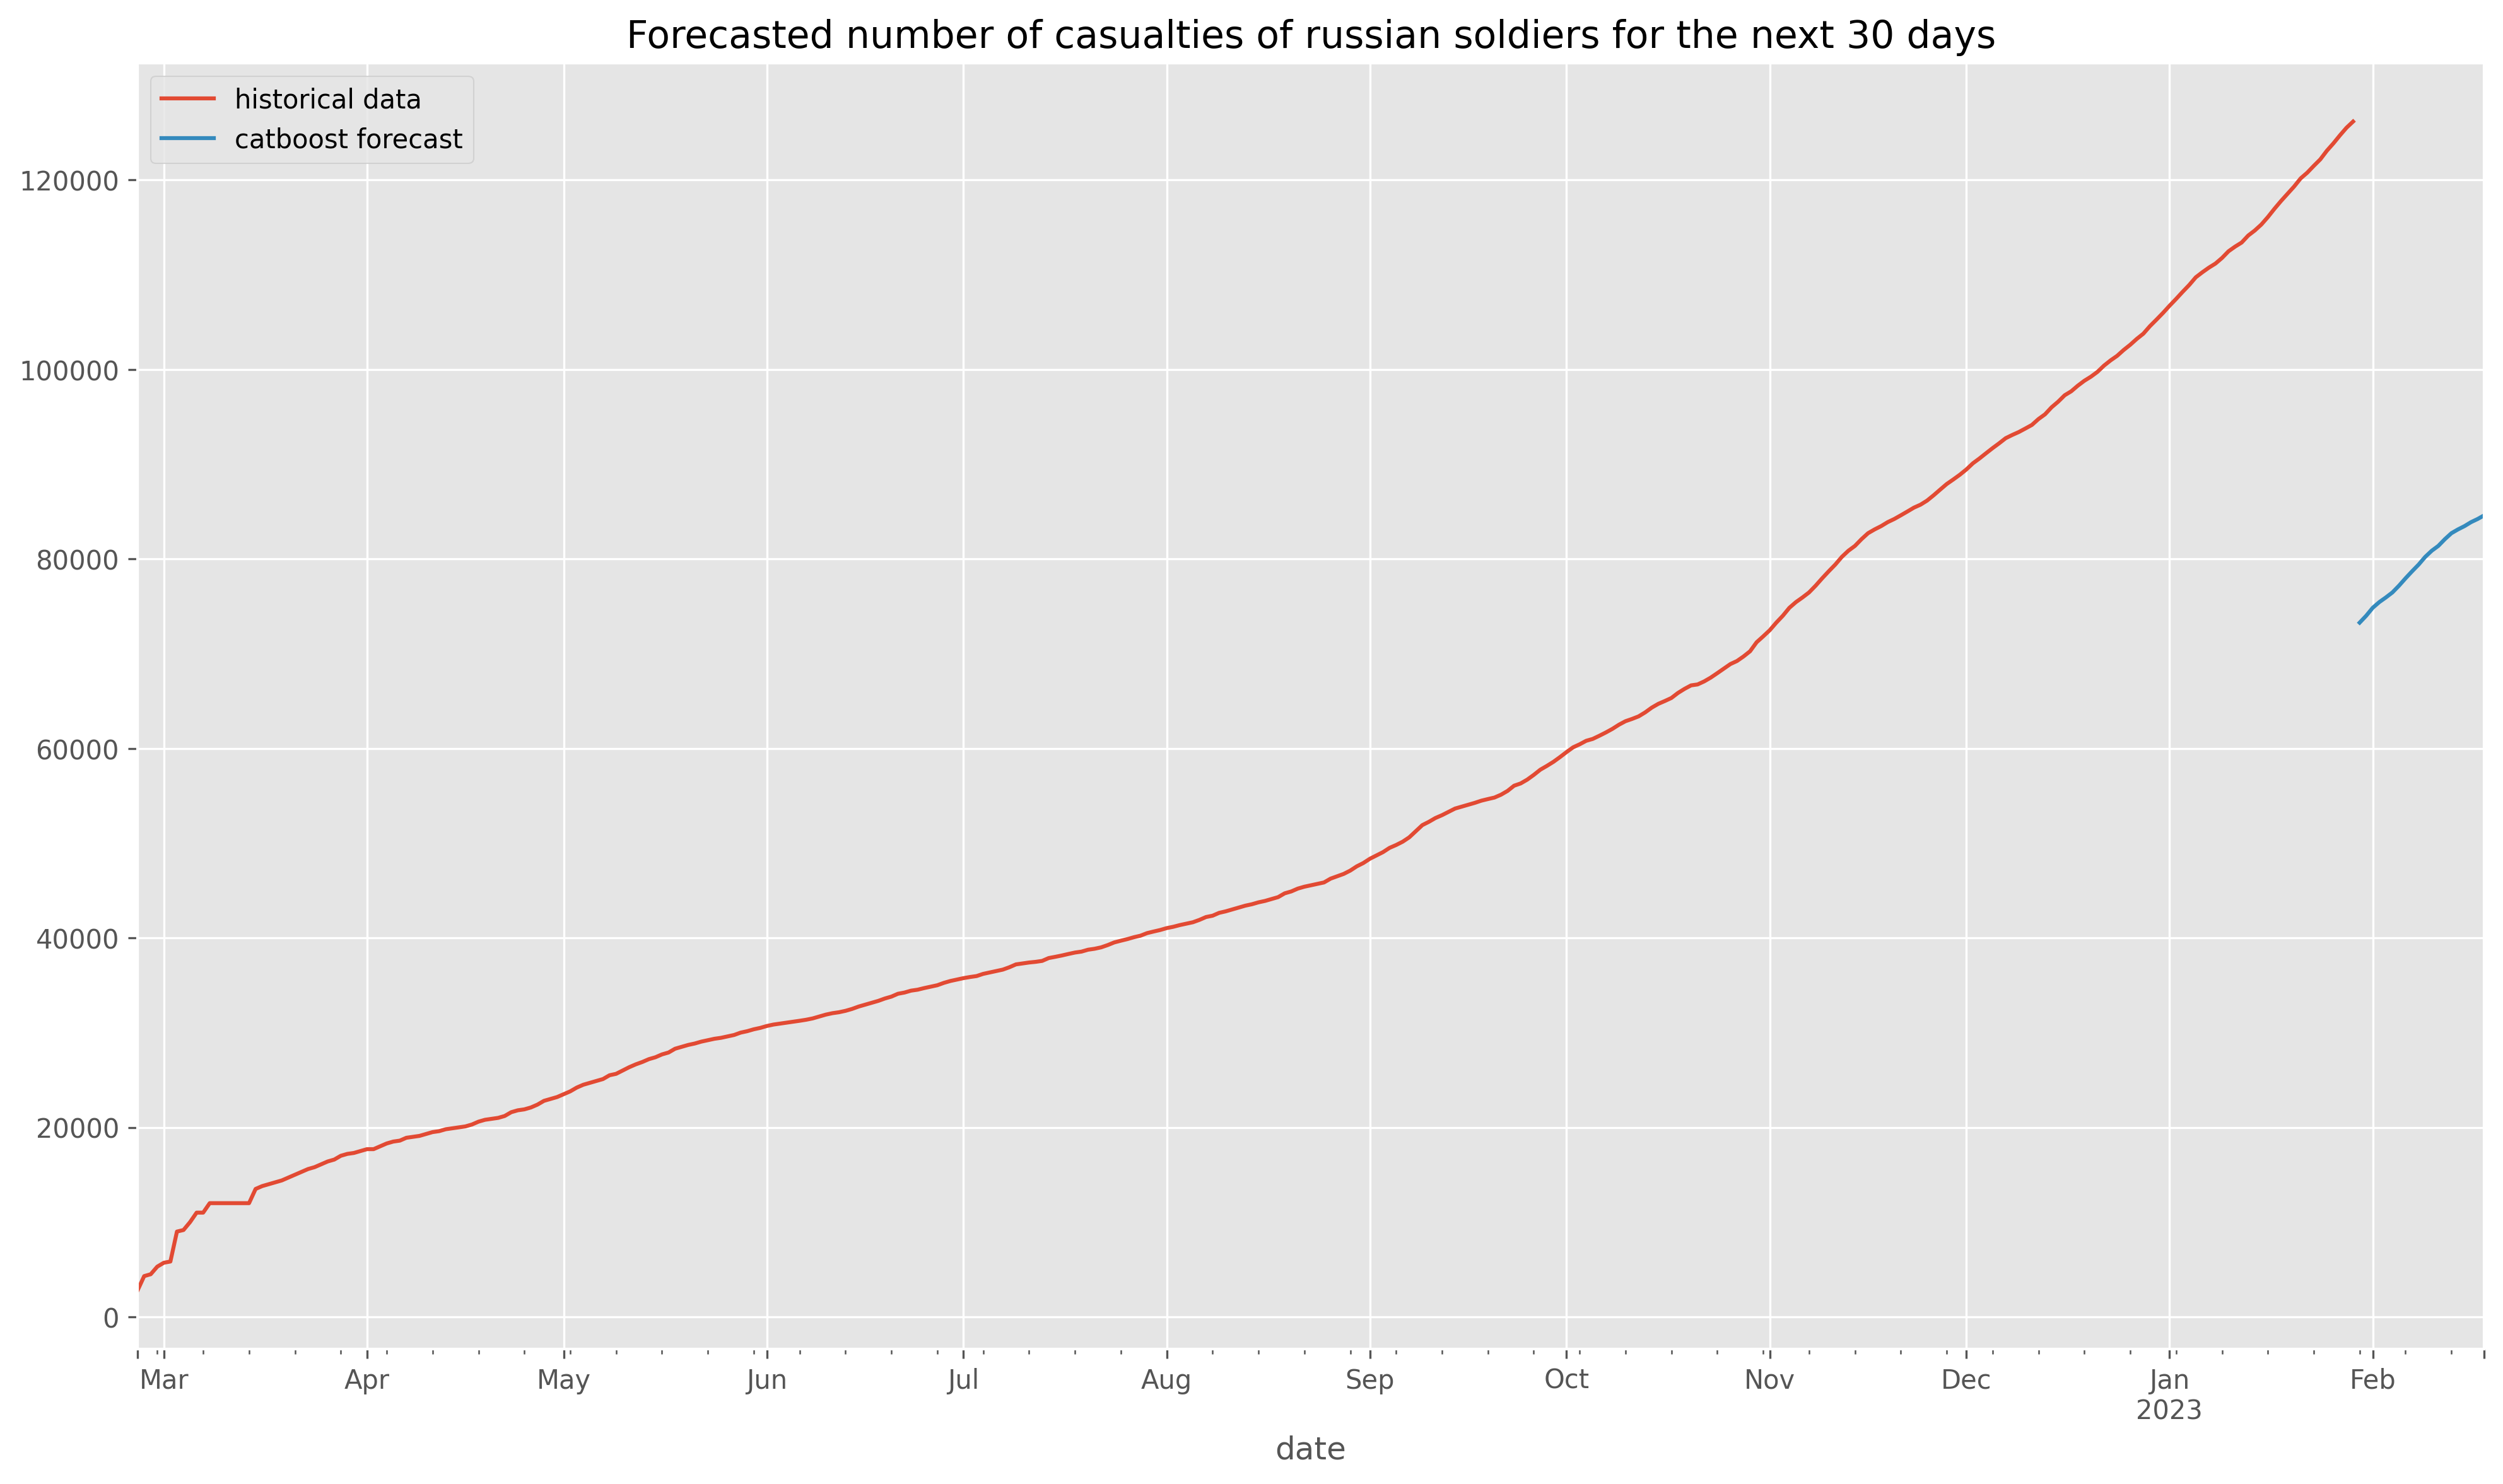

In [135]:
ru_losses_per['personnel'].plot(label = 'historical data')
preds.plot(label='catboost forecast')
plt.legend()
plt.title('Forecasted number of casualties of russian soldiers for the next 30 days')
plt.show()

We  can notice that our model is undershooting the predictions sistematically. But the trend behavior seems to be captured

In [141]:
y_adjustment = ru_losses_per['personnel'][-1] - preds[0]

In [143]:
avg_diff_between_days = ru_losses_per['personnel'].diff().mean()

In [144]:
preds2 = preds + y_adjustment + avg_diff_between_days

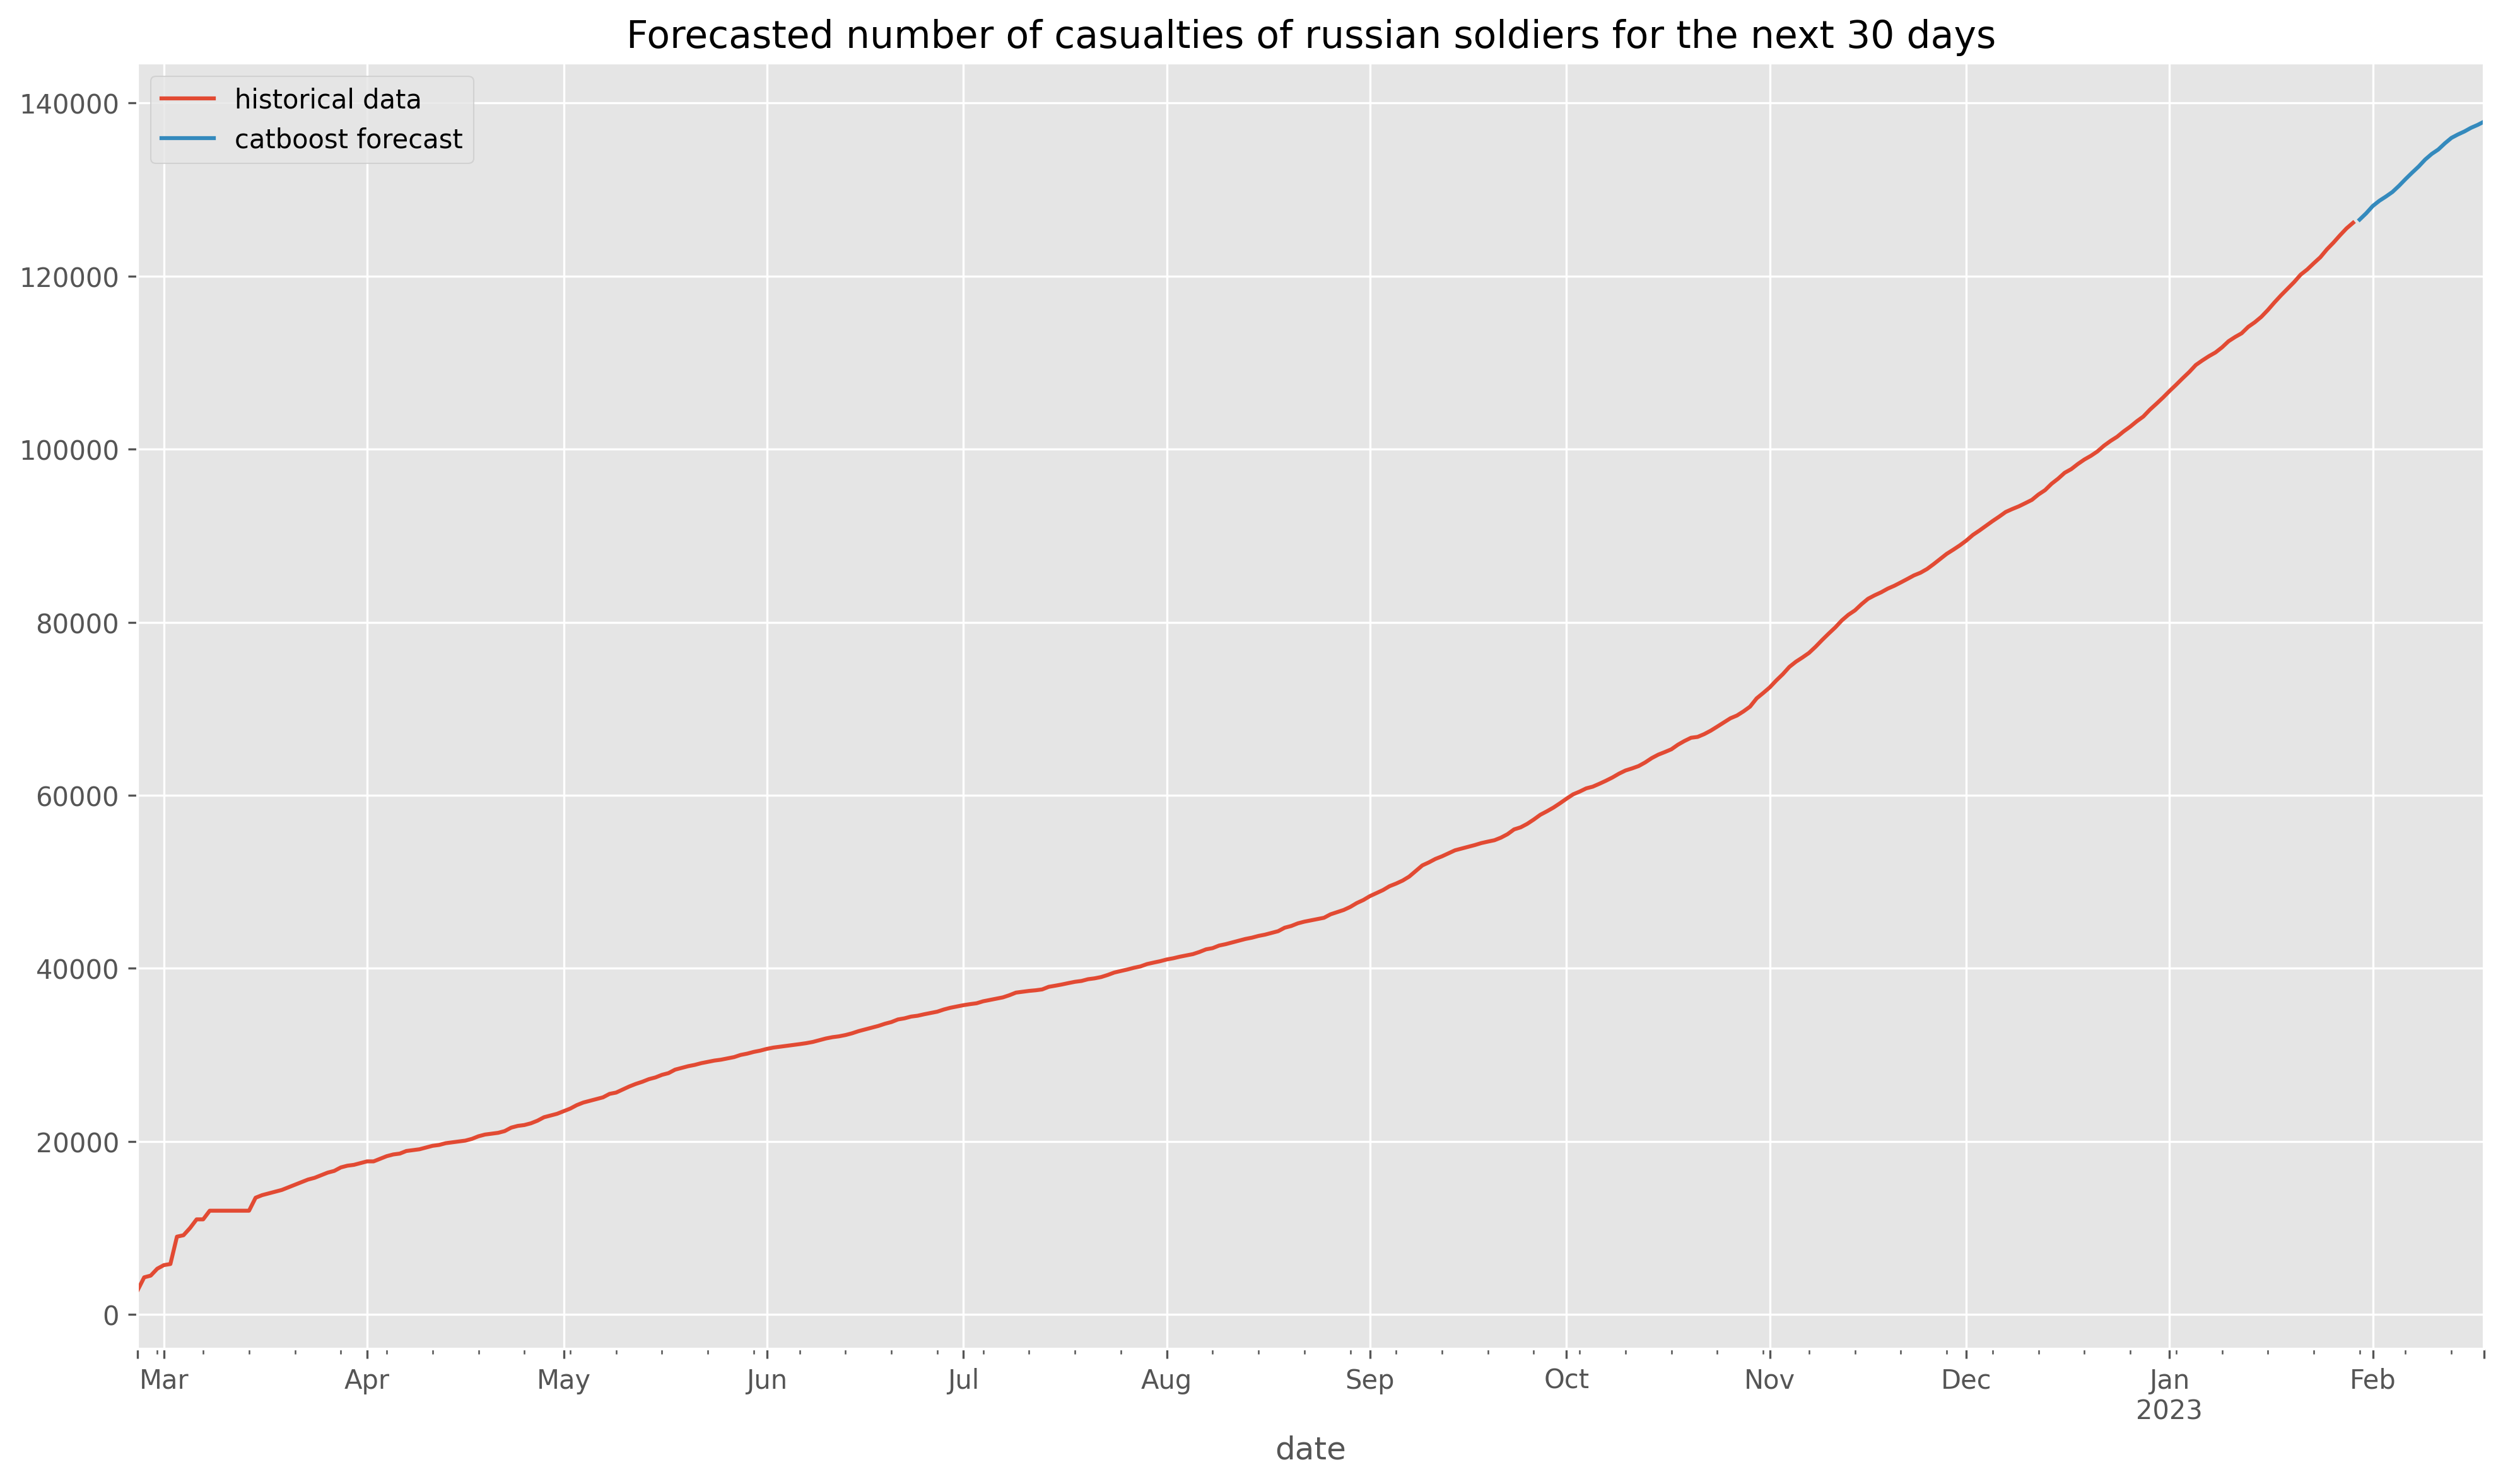

In [145]:
ru_losses_per['personnel'].plot(label = 'historical data')
preds2.plot(label='catboost forecast')
plt.legend()
plt.title('Forecasted number of casualties of russian soldiers for the next 30 days')
plt.show()

Now our predictions seems more reasonable 😸

In [146]:
import numpy as np
import pandas as pd
base = pd.Timestamp("2020-1-1")
gen = np.random.default_rng()
gaps = np.cumsum(gen.integers(0, 1800, size=1000))
times = [base + pd.Timedelta(gap, unit="s") for gap in gaps]
index = pd.DatetimeIndex(pd.to_datetime(times))

In [147]:
from statsmodels.tsa.deterministic import CalendarFourier
cal_fourier_gen = CalendarFourier("D", 2)
cal_fourier_gen.in_sample(index)

sin(1,freq=D)  cos(1,freq=D)  sin(2,freq=D)  \
2020-01-01 00:22:04       0.096135       0.995368       0.191380   
2020-01-01 00:37:19       0.162106       0.986773       0.319924   
2020-01-01 01:04:27       0.277524       0.960719       0.533245   
2020-01-01 01:31:20       0.388052       0.921638       0.715286   
2020-01-01 01:59:56       0.499748       0.866171       0.865734   
...                            ...            ...            ...   
2020-01-11 11:25:23       0.150470      -0.988615      -0.297514   
2020-01-11 11:54:15       0.025086      -0.999685      -0.050157   
2020-01-11 11:56:49       0.013889      -0.999904      -0.027776   
2020-01-11 12:13:43      -0.059815      -0.998210       0.119415   
2020-01-11 12:20:58      -0.091357      -0.995818       0.181950   

                     cos(2,freq=D)  
2020-01-01 00:22:04       0.981516  
2020-01-01 00:37:19       0.947443  
2020-01-01 01:04:27       0.845961  
2020-01-01 01:31:20       0.698832  
2020-01-01 01:59:56       0.500504  
...                            ...  
2020-01-11 11:25:23       0.954718  
2020-01-11 11:54:15       0.998741  
2020-01-11 11:56:49       0.999614  
2020-01-11 12:13:43       0.992844  
2020-01-11 12:20:58       0.983308  

[1000 rows x 4 columns]